# SPM Figure 1 design

Written by Stuart Jenkins and Richard Millar 

### The temperature panel (SR1.5 fig 1.1)

#### Overview

1. a) Import the necessary packages,

1. b) Define some useful functions: _load_\__colpal(...)_ and _load_\__stu_\__cols(...)_ to load the colour palette for the plots, and _try_\__or(...)_ which is used as a check on the lines to be drawn for each plot. Allows inline figure creation and manipulation.

2. Define the figure shape and axes within the figure (in the hashed region at the top of '__Plot 1__' section),

3. Import the observed temperature datasets and re-baseline them to a common reference period. OUTPUT PLOT 1.

4. Find the min, max and mean of those datasets. OUTPUT PLOT 2.

5. Use Piers Forster's radiative forcing dataset with FaIR to find anthropogenic and natural temperature anomaly. Re-baseline to common reference period. OUTPUT PLOT 3.

6. Use Ordinary Least Squares regression (OLS regression) technique to find AWI and NWI. OUTPUT PLOT 4.

7. Add the present day uncertainty on the AWI timeseies. OUTPUT PLOT 5.

### Temperature plumes with associated scenario panel (SR1.5 SPM fig 1)

#### Overview

1. a) Import the necessary packages,

1. b) Define some useful functions: _load_\__colpal(...)_ and _load_\__stu_\__cols(...)_ to load the colour palette for the plots, and _try_\__or(...)_ which is used as a check on the lines to be drawn for each plot. Allows inline figure creation and manipulation.

2. Define the figure shape and axes within the figure (in the hashed region at the top of '__Plot 1__' section),

3. Import the observed temperature datasets and re-baseline them to a common reference period. OUTPUT PLOT 1.

4. Find the min, max and mean of those datasets. OUTPUT PLOT 2.

5. Use Piers Forster's radiative forcing dataset with FaIR to find anthropogenic and natural temperature anomaly. Re-baseline to common reference period. OUTPUT PLOT 3.

6. Use Ordinary Least Squares regression (OLS regression) technique to find AWI and NWI. OUTPUT PLOT 4.

7. Add the present day uncertainty on the AWI timeseies. OUTPUT PLOT 5.

<br>
<br>
<br>
<br>
<br>
<br>

## The temperature panel

Import necessary external packages for the figure creation.

Define some useful external functions for use throughout script:
   - load colours for use in plots (_load_\__colpal()_ & _load_\__stu_\__cols()_)
   
   - define try_or() function for removing lines from figures when repeatedly replotting

In [1]:
from IPython.display import display
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
from scipy.special import erf, erfinv
from scipy.optimize import root
from scipy.stats import norm, beta
from statsmodels.api import OLS
import statsmodels.tools.tools
import datetime
import os
import h5py
import copy
from pandas import DataFrame
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from matplotlib.legend_handler import HandlerTuple
from fair_scm import *

def load_colpal():
    rgb_list = np.array([[0,0,0],[230,159,0],[86,180,233],[0,158,115],
                [240,228,66],[0,114,178],[213,94,0],[204,121,167]]) / 255.
    
    rgb_names = ['black','orange','skyblue','bluishgreen','yellow',
                'blue','vermillion','reddishpurple']
                
    rgbs = {rgb_names[x]:tuple(rgb_list[x]) for x in range(0,len(rgb_list))}
    
    return rgbs

def load_stu_cols():
    stu_rgb_list = np.array([[0,0,0],[110,110,110],[175, 221, 218],[14, 178, 167],[229, 73, 181]]) / 255.
    
    stu_rgb_names = ['black','line_grey','pale_blue','line_blue','line_purple']
    
    stu_rgbs = {stu_rgb_names[x]:tuple(stu_rgb_list[x]) for x in range(0,len(stu_rgb_list))}
    
    return stu_rgbs

def try_or(lines):
    if lines == None:
        return
    else:
        for num in range(len(lines)-1,-1,-1):
            lines[num].remove()
            del lines[num]
            
    return lines
    
cols = load_colpal()
stu_cols = load_stu_cols()

/Users/stuartjenkins/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<br>
## Plot 1 - Observed temperature datasets

Define figure shape, import the 4 temperature datasets and baseline them to the same common reference period. 

Plot results in style of Fig 1.1 (SR1.5).

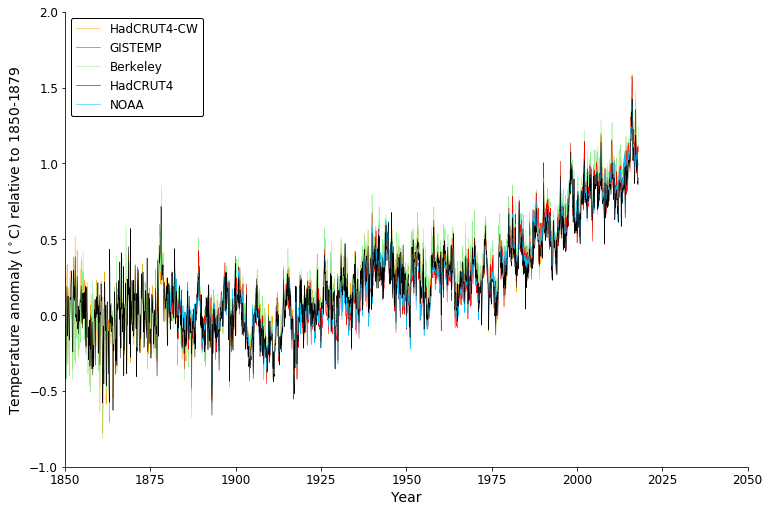

In [2]:
####################################################################################
####################################################################################
# DEFINE FIGURE (LIKE SR1.5 FIG1.1)
####################################################################################
####################################################################################
                                                                                                    
# define figure shape
main_xstart = 0.13                                                                                  
main_xwidth = 0.79                                                                                   
main_ystart = 0.11                                                                                  
main_ywidth = 0.79                                                                                  
                                                                                                    
# create figure with axes (empty)
fig_temp = plt.figure(figsize = (12,8))  
ax_main = fig_temp.add_axes([main_xstart,main_ystart,main_xwidth,main_ywidth])                      
ax_main.spines['right'].set_visible(False)                                                          
ax_main.spines['top'].set_visible(False)                                                        
ax_main.set_xlim(1850,2050)                                                                         
ax_main.set_ylim(-1,2)                                                                              
ax_main.set_xlabel('Year', fontsize = 14)                                                  
ax_main.set_ylabel(r'Temperature anomaly ($^\circ$C) relative to 1850-1879', fontsize = 14)
ax_main.tick_params(axis='both', which='major', labelsize=12)                                                  

# prepare arrays to contain lines on plot later
lines_gwi = None
lines_minmax = None
legends = []

####################################################################################
####################################################################################
# END DEFINE FIGURE
####################################################################################
####################################################################################



#import and rebaseline the observations ready for plotting
base_low=1850.
base_high=1900.
com_ref_low=1880.
com_ref_high=2017.
temp_freq='mon'

## Import the temperature observation datasets ##
#Specify the GMST best-estimate temperature timeseries files 
gmst_files = {'HadCRUT4':'./Data/HadCRUT.4.6.0.0.monthly_ns_avg.txt',
'GISTEMP':'./Data/GLB.Ts+dSST.csv',
'NOAA':'./Data/aravg.mon.land_ocean.90S.90N.v4.0.1.201803.asc',
'Berkeley':'./Data/Land_and_Ocean_complete.txt',
'HadCRUT4-CW':'./Data/had4_krig_v2_0_0.txt'}

gmst_names = gmst_files.keys()
years_com = np.arange(1850. + 1./24,1850. + 1./24 + (2020)*1./12,1.0/12)[:-1]
gmst = {}

for key in gmst_names:
    
    if key in ['HadCRUT4','HadCRUT4-CW']:
        data = np.genfromtxt(gmst_files[key])
        temps = data[:,1]
        years = years_com[:len(temps)]

    if key in ['GISTEMP']:
        f_giss = open(gmst_files[key],'r')
        temps = []
        counter = 0
        for line in f_giss:
          if counter>=2:
              temps.extend([float(f) for f in line.split(',')[1:13] if f != '***'])
          counter = counter + 1
        temps=np.array(temps)
        years = years_com[years_com>1880.][:len(temps)]

    if key in ['NOAA']:
        data = np.genfromtxt(gmst_files[key])
        temps = data[:,2]
        years = years_com[years_com>1880.][:len(temps)]

    if key in ['Berkeley']:
        data = np.genfromtxt(gmst_files[key])
        temps = data[:,2]
        years = years_com[:len(temps)]


    gmst[key] = {'Temp':temps,'Years':years}

#Set the datasets to a common reference period        
hc_ref = np.mean(gmst['HadCRUT4']['Temp'][np.logical_and(gmst['HadCRUT4']['Years']>=com_ref_low,
                gmst['HadCRUT4']['Years']<(com_ref_high+1))]) - np.mean(gmst['HadCRUT4']['Temp'][np.logical_and(gmst['HadCRUT4']['Years']>=base_low,
                                                gmst['HadCRUT4']['Years']<(base_high+1))])
for key in gmst_names:
    gmst[key]['Temp'] = gmst[key]['Temp'][gmst[key]['Years'] < 2018.]
    gmst[key]['Years'] = gmst[key]['Years'][gmst[key]['Years'] < 2018.]
    #Express relative to a common base period
    gmst[key]['Temp'] = gmst[key]['Temp'] - np.mean(gmst[key]['Temp'][np.logical_and(gmst[key]['Years']>=com_ref_low,
                                                              gmst[key]['Years']<(com_ref_high+1))])
    #Set NOAA and GISTEMP datasets relative to HadCRUT4 value over the base period 
    if key in ['NOAA','GISTEMP']:
        gmst[key]['Temp'] = gmst[key]['Temp'] + hc_ref
    else: 
        gmst[key]['Temp'] = gmst[key]['Temp'] - np.mean(gmst[key]['Temp'][np.logical_and(gmst[key]['Years']>=base_low,
                                                                              gmst[key]['Years']<(base_high+1))])

#plot the temperature observations on the axes
colours = {'Berkeley':'lightgreen', 'HadCRUT4':'black', 'GISTEMP':'red', 'NOAA':'deepskyblue', 'HadCRUT4-CW':'orange'}
order = {'Berkeley':2, 'HadCRUT4':5, 'GISTEMP':3, 'NOAA':4, 'HadCRUT4-CW':1}
lines_dict = {'Berkeley':'','HadCRUT4':'', 'GISTEMP':'', 'NOAA':'', 'HadCRUT4-CW':''}
lines = []

for key in gmst_names:
    lines_dict[key], = ax_main.plot(gmst[key]['Years'],gmst[key]['Temp'], color=colours[key], alpha = 1, zorder = order[key], label = key, linewidth=0.5)
    lines.append(lines_dict[key])

legend1 = ax_main.legend(loc='best', edgecolor='black', framealpha=1, fontsize = 12)
legends.append(legend1)

plt.show();
fig_temp.savefig('./bookletfigs/plot1.pdf',dpi=300)

<br>
## Plot 2 - Min, max and mean observations

Check if lines are already drawn, remove unwanted lines from plot (in hashed region).

Calculate the minimum, maximum and mean value of each datapoint in the observed temperature datasets.

Plot them on same axes as above (red - max, blue - min, black - mean).

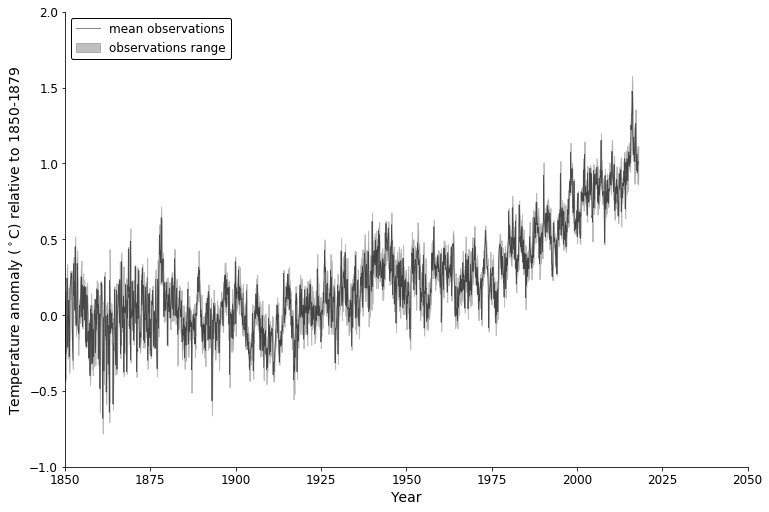

In [3]:
try: temp_mean_line             
except NameError: pass                      
else: temp_mean_line.remove(); del temp_mean_line  
legends = try_or(legends)
lines_minmax = try_or(lines_minmax)
lines_gwi = try_or(lines_gwi)
lines = try_or(lines)
###############################################################



#Calculate the max, min and mean obs in every month...
obs_max = np.zeros_like(gmst['HadCRUT4']['Years'])
obs_min = np.zeros_like(gmst['HadCRUT4']['Years'])
obs_mean = np.zeros_like(gmst['HadCRUT4']['Years'])
for y in range(0,len(gmst['HadCRUT4']['Years'])): 
    year_vals = []
    #Loop over AR5 datasets and HadCRUT4-CW
    for ob in ['HadCRUT4','NOAA','GISTEMP','HadCRUT4-CW']:
        val = gmst[ob]['Temp'][gmst[ob]['Years']==gmst['HadCRUT4']['Years'][y]]
        if len(val)>0:
            year_vals.append(val)
    obs_max[y] = np.max(year_vals)
    obs_min[y] = np.min(year_vals)
    obs_mean[y] = np.mean(year_vals)

# save as entries in gmst
gmst['Temp-max'] = obs_max
gmst['Temp-min'] = obs_min
gmst['Temp-mean'] = obs_mean

# add max, min and mean lines of observed temp data to plot
#temp_min_line, = ax_main.plot(gmst['HadCRUT4']['Years'],np.array(gmst['Temp-min']),color='blue',linestyle='-', alpha = 0.75,lw=1,label='min observations')
#temp_max_line, = ax_main.plot(gmst['HadCRUT4']['Years'],np.array(gmst['Temp-max']),color='red',linestyle='-',alpha = 0.75,lw=1,label='max observations')
temp_mean_line, = ax_main.plot(gmst['HadCRUT4']['Years'],np.array(gmst['Temp-mean']),color='black',linestyle='-',lw=0.8,label='mean observations', alpha=0.6)
#lines_minmax = [temp_min_line, temp_max_line]

# so that it can be added later!!!
fill_obs_range = ax_main.fill_between(gmst['HadCRUT4']['Years'], gmst['Temp-max'],gmst['Temp-min'],color='grey',alpha=0.5, label='observations range')   

legend2 = ax_main.legend(loc='upper left', edgecolor='black', framealpha = 1, fontsize = 12)
legends.append(legend2)

# display figure
display(fig_temp)
fig_temp.savefig('./bookletfigs/plot2.pdf',dpi=300)

<br>
## Plot 3 - Anthropogenic and natural contributions

Check if lines are already drawn, remove unwanted lines from plot (in hashed region).

Calculate natural and anthropogenic temperature timeseries from Piers RF dataset (using FaIR).

Plot them on same axes as above (light grey - temp. range (obs), dark grey - temp. mean (obs), orange - T_anthro, blue - T_nat).

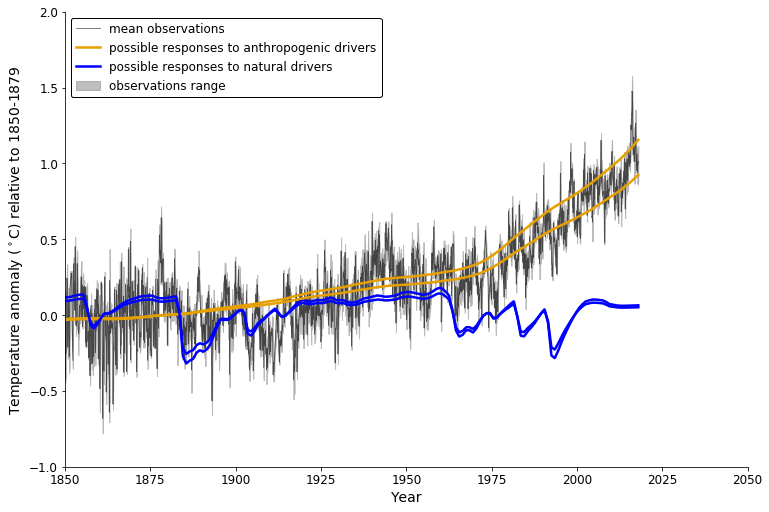

In [4]:
######################################
legends = try_or(legends)
#lines_minmax = try_or(lines_minmax)
lines_gwi = try_or(lines_gwi)
#fill_obs_range.set_alpha(0.5)               
temp_mean_line.set_alpha(0.6)                               
######################################


# define observations and baseline timeframe
obs = gmst['Temp-mean']
obs_years = gmst['HadCRUT4']['Years']
reg_type='mon'
base_low=1850.
base_high=1900

# load the best estimate forcings from Piers
forc_file = './Data/Annualforcings_Mar2014_GHGrevised.txt'
data = np.genfromtxt(forc_file,skip_header=4)
years = data[:,0]
tot_forc = data[:,13]
ant_forc = data[:,14]

####################################
# with standard fair parameters...
####################################
# integrate anthropogenic and natural forcing with standard FAIR parameters
C, t_nat = fair_scm(other_rf=tot_forc-ant_forc)
C, t_anthro = fair_scm(other_rf=ant_forc)
# express relative to the centre of the base period
t_nat = t_nat - np.mean(t_nat[np.logical_and(years>=base_low,years<base_high+1)])
t_anthro = t_anthro - np.mean(t_anthro[np.logical_and(years>=base_low,years<base_high+1)])

# interpolate the annual forced responses to the grid of the observed data
if reg_type !='mon':
    t_nat = np.interp(obs_years+0.5, years+0.5, t_nat)
    t_anthro = np.interp(obs_years+0.5, years+0.5, t_anthro)
else:
    t_nat = np.interp(obs_years, years+0.5, t_nat)
    t_anthro = np.interp(obs_years, years+0.5, t_anthro)

# linearly project the final half year
t_anthro[obs_years>(years[-1]+0.5)] = 12*(t_anthro[obs_years<=(years[-1]+0.5)][-1] - t_anthro[obs_years<=(years[-1]+0.5)][-2]) * (obs_years[obs_years>(years[-1]+0.5)] - obs_years[obs_years<=(years[-1]+0.5)][-1]) \
+t_anthro[obs_years<=(years[-1]+0.5)][-1]
t_nat[obs_years>(years[-1]+0.5)] = 12*(t_nat[obs_years<=(years[-1]+0.5)][-1] - t_nat[obs_years<=(years[-1]+0.5)][-2]) * (obs_years[obs_years>(years[-1]+0.5)] - obs_years[obs_years<=(years[-1]+0.5)][-1]) \
+t_nat[obs_years<=(years[-1]+0.5)][-1]
####################################
####################################

####################################
# fair run with 0.8*TCR and ECS values...
####################################
# integrate anthropogenic and natural forcing with standard FAIR parameters
C, t_nat_red = fair_scm(other_rf=tot_forc-ant_forc, tcrecs=([1.6*0.8,2.75*0.8]))
C, t_anthro_red = fair_scm(other_rf=ant_forc, tcrecs=([1.6*0.8,2.75*0.8]))
# express relative to the centre of the base period
t_nat_red = t_nat_red - np.mean(t_nat_red[np.logical_and(years>=base_low,years<base_high+1)])
t_anthro_red = t_anthro_red - np.mean(t_anthro_red[np.logical_and(years>=base_low,years<base_high+1)])

# interpolate the annual forced responses to the grid of the observed data
if reg_type !='mon':
    t_nat_red = np.interp(obs_years+0.5, years+0.5, t_nat_red)
    t_anthro_red = np.interp(obs_years+0.5, years+0.5, t_anthro_red)
else:
    t_nat_red = np.interp(obs_years, years+0.5, t_nat_red)
    t_anthro_red = np.interp(obs_years, years+0.5, t_anthro_red)

# linearly project the final half year
t_anthro_red[obs_years>(years[-1]+0.5)] = 12*(t_anthro_red[obs_years<=(years[-1]+0.5)][-1] - t_anthro_red[obs_years<=(years[-1]+0.5)][-2]) * (obs_years[obs_years>(years[-1]+0.5)] - obs_years[obs_years<=(years[-1]+0.5)][-1]) \
+t_anthro_red[obs_years<=(years[-1]+0.5)][-1]
t_nat_red[obs_years>(years[-1]+0.5)] = 12*(t_nat_red[obs_years<=(years[-1]+0.5)][-1] - t_nat_red[obs_years<=(years[-1]+0.5)][-2]) * (obs_years[obs_years>(years[-1]+0.5)] - obs_years[obs_years<=(years[-1]+0.5)][-1]) \
+t_nat_red[obs_years<=(years[-1]+0.5)][-1]
####################################
####################################

# add forcing driven anthropogenic and natural temperatures to plot
t_anthro_line, = ax_main.plot(obs_years, t_anthro, color=cols['orange'], linestyle='-', linewidth=2.5, label = 'possible responses to anthropogenic drivers')
t_nat_line, = ax_main.plot(obs_years, t_nat, color='blue', linestyle='-', linewidth=2.5, label = 'possible responses to natural drivers')

t_anthro_red_line, = ax_main.plot(obs_years, t_anthro_red, color=cols['orange'], linestyle='-', linewidth=2.5)
t_nat_red_line, = ax_main.plot(obs_years, t_nat_red, color='blue', linestyle='-', linewidth=2.5)

lines_gwi = [t_anthro_line, t_nat_line, t_anthro_red_line, t_nat_red_line]
legend3 = ax_main.legend(loc = 'upper left', framealpha = 1, edgecolor = 'black', fontsize = 12)
legends.append(legend3)

# display figure
display(fig_temp)
fig_temp.savefig('./bookletfigs/plot3.pdf',dpi=300)

<br>
## Plot 4 - Finding AWI and NWI using OLS regression

Check if lines are already drawn, remove unwanted lines from plot (in hashed region).

Use OLS regression to find the best estimate contributions to observed temperatures from t_anthro and t_nat (i.e. find AWI and NWI).

Plot them on the same axes as above (light grey - temp. range (obs), dark grey - temp. mean (obs), orange - AWI, blue - NWI).

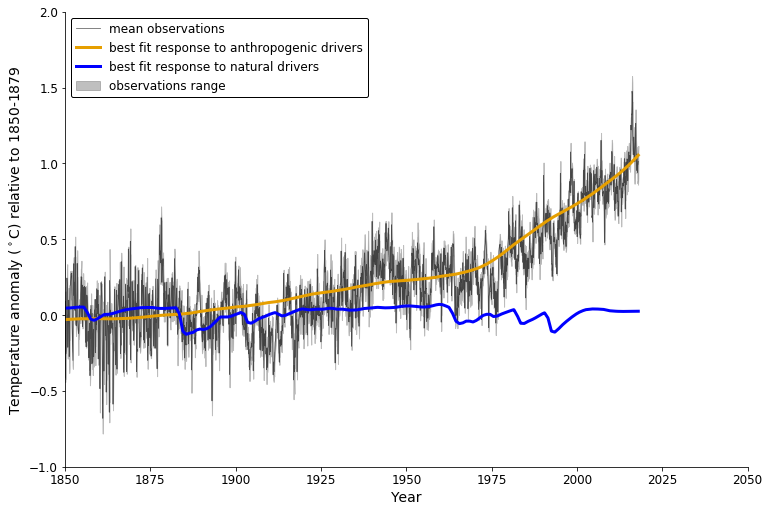

In [5]:
####################################
legends = try_or(legends)
lines_gwi = try_or(lines_gwi)
lines_minmax = try_or(lines_minmax)
####################################

########################################################################
# define function to complete OLS regression analysis of dataset
########################################################################
def calc_gwi(obs,obs_years,reg_type='mon',base_low=1850.,base_high=1900):
    
    #Express the observations relative to the base period 
    obs = obs - np.mean(obs[np.logical_and(obs_years>=base_low,obs_years<(base_high+1))])

    #Load the best estimate forcings from Piers
    forc_file = './Data/Annualforcings_Mar2014_GHGrevised.txt'
    data = np.genfromtxt(forc_file,skip_header=4)
    years = data[:,0]
    tot_forc = data[:,13]
    ant_forc = data[:,14]

    #Integrate anthropogenic and natural forcing with standard FAIR parameters
    C, t_nat = fair_scm(other_rf=tot_forc-ant_forc)
    C, t_anthro = fair_scm(other_rf=ant_forc)
    #Express relative to the centre of the base period
    t_nat = t_nat - np.mean(t_nat[np.logical_and(years>=base_low,years<base_high+1)])
    t_anthro = t_anthro - np.mean(t_anthro[np.logical_and(years>=base_low,years<base_high+1)])

    #Interpolate the annual forced responses to the grid of the observed data
    if reg_type !='mon':
        t_nat = np.interp(obs_years+0.5, years+0.5, t_nat)
        t_anthro = np.interp(obs_years+0.5, years+0.5, t_anthro)
    else:
        t_nat = np.interp(obs_years, years+0.5, t_nat)
        t_anthro = np.interp(obs_years, years+0.5, t_anthro)

    #Linearly project the final half year
    t_anthro[obs_years>(years[-1]+0.5)] = 12*(t_anthro[obs_years<=(years[-1]+0.5)][-1] - t_anthro[obs_years<=(years[-1]+0.5)][-2]) * (obs_years[obs_years>(years[-1]+0.5)] - obs_years[obs_years<=(years[-1]+0.5)][-1]) \
    +t_anthro[obs_years<=(years[-1]+0.5)][-1]
    t_nat[obs_years>(years[-1]+0.5)] = 12*(t_nat[obs_years<=(years[-1]+0.5)][-1] - t_nat[obs_years<=(years[-1]+0.5)][-2]) * (obs_years[obs_years>(years[-1]+0.5)] - obs_years[obs_years<=(years[-1]+0.5)][-1]) \
    +t_nat[obs_years<=(years[-1]+0.5)][-1]

    #OLS regression of observations data on natural and anthropogenic warming with a constant
    y = np.copy(obs)
    x = DataFrame({'x1': (t_anthro), 'x2': (t_nat)})
    x = statsmodels.tools.tools.add_constant(x)
    model = OLS(y, x)
    result = model.fit()
    sf = result.params

    #Form scaled anthropgenic warming index
    awi = t_anthro * sf['x1']
    #Scaled natural warming index
    nwi = t_nat * sf['x2']
    #Scaled total externally forced warming index
    gwi = awi + nwi

    return awi, nwi
########################################################################
########################################################################



# calculate the AWI and NWI for each GMST dataset relative to the baseperiod and
#      also for the mean of the datasets 
for key in gmst_names:
    awi, nwi = calc_gwi(gmst[key]['Temp'],gmst[key]['Years'],reg_type=temp_freq,
                        base_low=base_low,base_high=base_high)
    # express AWI and NWI relative the mid-point of the period
    gmst[key]['AWI'] = awi 
    gmst[key]['NWI'] = nwi 

# calculte for the mean of the datasets
awi, nwi = calc_gwi(gmst['Temp-mean'],gmst['HadCRUT4']['Years'],reg_type=temp_freq,
                    base_low=base_low,base_high=base_high)
gmst['Temp-mean-AWI'] = awi 
gmst['Temp-mean-NWI'] = nwi


# plot the OLS regression fitted AWI and NWI values. 
t_anthro_line, = ax_main.plot(gmst['HadCRUT4']['Years'], gmst['Temp-mean-AWI'], 
                              color=cols['orange'], linestyle='-', linewidth=3, label='best fit response to anthropogenic drivers')
t_nat_line, = ax_main.plot(gmst['HadCRUT4']['Years'], gmst['Temp-mean-NWI'], 
                           color='blue', linestyle='-', linewidth=3, label='best fit response to natural drivers')  
lines_gwi = [t_anthro_line, t_nat_line]
legend4 = ax_main.legend(loc='upper left', edgecolor = 'black', framealpha = 1, fontsize = 12)
legends.append(legend4)

# display figure
display(fig_temp)
fig_temp.savefig('./bookletfigs/plot4.pdf',dpi=300)

<br>
## Plot 5 - Adding present day uncertainty to AWI

Check if lines are already drawn, remove unwanted lines from plot (in hashed region).

Plot shaded region on AWI expressing uncertainty on the present day value. 

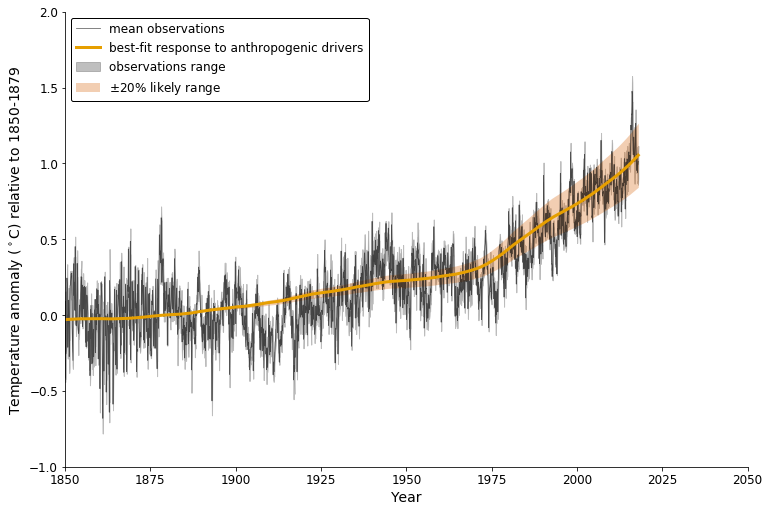

In [6]:
#####################################
legends = try_or(legends)
lines_gwi = try_or(lines_gwi)
lines_minmax = try_or(lines_minmax)
#####################################


# add the AWI line only to plot (i.e. redraw without natural warming index)
t_anthro_line, = ax_main.plot(gmst['HadCRUT4']['Years'], gmst['Temp-mean-AWI'], 
                              color=cols['orange'], linestyle='-', linewidth=3, label='best-fit response to anthropogenic drivers')

# add uncertainty to AWI timeseries
AWI_uncert = ax_main.fill_between(gmst['HadCRUT4']['Years'],gmst['Temp-mean-AWI']*(1.2),
                 gmst['Temp-mean-AWI']*(0.8), 
                 color=cols['vermillion'],alpha=0.3,linewidth=0, label='$\pm$20% likely range')
lines_gwi = [t_anthro_line, AWI_uncert]
legend5 = ax_main.legend(loc='upper left', framealpha=1, edgecolor='black', fontsize=12)
legends.append(legend5)

# display figure
display(fig_temp)
fig_temp.savefig('./bookletfigs/plot5.pdf',dpi=300)

<br>
<br>
<br>
<br>

# Temperature plumes with associated scenario panel (SR1.5 SPM fig 1)

## Plot 6 - Creating SPM figure 1 shape

Define figure shape with main panel as temperature panel (plot 5), but with subpanels below containing information on the scenario.

Majority of this box contains code defining the initial figure shape so it can be populated later. 

Populates main temperature panel with lines from lot 5 and adds a projection of current warming rate and line marking the location of year 2017, and 1.5$^\circ$C.

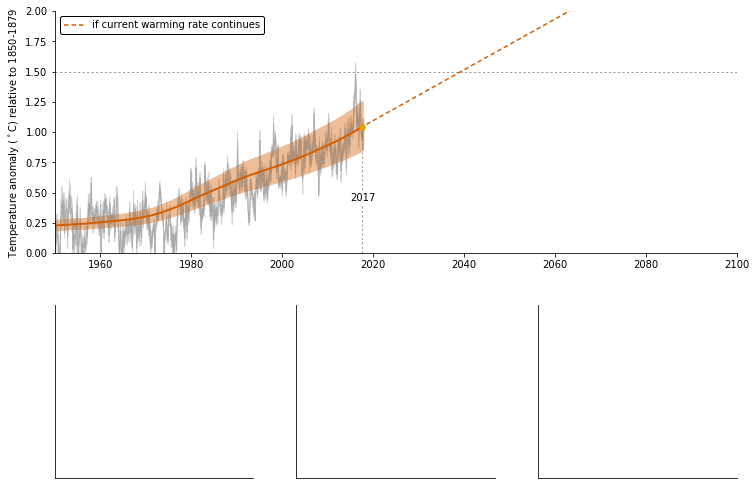

In [7]:
###############################################################################
###############################################################################
# DEFINE THE SPM FIGURE 1 SHAPE
###############################################################################
###############################################################################
                                                                                                    
# define a figure shape - locations and sizes of axes
main_xstart = 0.13; main_xwidth = 0.79; main_ystart = 0.50; main_ywidth = 0.42
left_xstart = 0.13; left_xwidth = 0.23; left_ystart = 0.11; left_ywidth = 0.30
mid_xstart = 0.41; mid_xwidth = 0.23; mid_ystart = 0.11; mid_ywidth = 0.30
right_xstart = 0.69; right_xwidth = 0.23; right_ystart = 0.11; right_ywidth = 0.30

# define the figure
fig = plt.figure(figsize=(12,8))
# define the left subplot
ax_left = fig.add_axes([left_xstart,left_ystart,left_xwidth,left_ywidth])
ax_left.spines['right'].set_visible(False)
ax_left.spines['top'].set_visible(False)
ax_left.tick_params(colors='white')
ax_left.set_xlim(1950,2100)
ax_left.set_ylim(0,55)
left_text = ax_left.text(0.97,1.0,'Annual CO$_{2}$ emissions',fontsize=12,
                         transform=ax_left.transAxes,ha='right',color='white')
# define the middle subplot
ax_middle = fig.add_axes([mid_xstart,mid_ystart,mid_xwidth,mid_ywidth])
ax_middle.spines['right'].set_visible(False)
ax_middle.spines['top'].set_visible(False)
ax_middle.tick_params(colors='white')
ax_middle.set_xlim(1950,2100)
ax_middle.set_ylim(0,3500)
mid_text = ax_middle.text(0.97,1.0,'Cumulative CO$_{2}$ emissions', 
               fontsize=12,transform=ax_middle.transAxes, 
               ha='right', color='white')
# define the right subplot
ax_right = fig.add_axes([right_xstart,right_ystart,right_xwidth,right_ywidth])
ax_right.spines['right'].set_visible(False)
ax_right.spines['top'].set_visible(False)
ax_right.tick_params(colors='white')
ax_right.set_xlim(1950,2100)
ax_right.set_ylim(0,1)
right_text = ax_right.text(0.97,1.0,'Non-CO$_{2}$ radiative forcing', 
               fontsize=12,transform=ax_right.transAxes, 
               ha='right', color='white')
# define the main subplot
ax_main_fig = fig.add_axes([main_xstart,main_ystart,main_xwidth,main_ywidth])
ax_main_fig.spines['right'].set_visible(False)
ax_main_fig.spines['top'].set_visible(False)
ax_main_fig.set_xlim(1950,2100)
ax_main_fig.set_ylim(0,2)
ax_main_fig.set_ylabel(r'Temperature anomaly ($^\circ$C) relative to 1850-1879')

# add the lines which were on the last plot to this one
ax_main_fig.fill_between(gmst['HadCRUT4']['Years'],gmst['Temp-max'],gmst['Temp-min'],
                     color='grey',alpha=0.3)
ax_main_fig.plot(gmst['HadCRUT4']['Years'],np.array(gmst['Temp-mean']),color='grey',
             linestyle='-',linewidth=1, alpha = 0.4)
ax_main_fig.plot(gmst['HadCRUT4']['Years'], gmst['Temp-mean-AWI'], color=cols['vermillion'],
             linestyle='-', linewidth=2)
ax_main_fig.fill_between(gmst['HadCRUT4']['Years'],gmst['Temp-mean-AWI']*(1.2),
                 gmst['Temp-mean-AWI']*(0.8),color=cols['vermillion'],
                 alpha=0.4,linewidth=0)

# prepare arrays to contain the lines in each of the created subplots
lines_main = None
lines_right = None
lines_middle = None
lines_left = None
###############################################################################
###############################################################################
# END OF MAIN FIGURE CREATION
###############################################################################
###############################################################################



# Add a line showing the position of 2017 and current temperature gradient
#  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  
warm_end = np.mean(gmst['Temp-mean-AWI'][np.logical_and(np.array(gmst['HadCRUT4']['Years'])>=2017,
                   np.array(gmst['HadCRUT4']['Years'])<2018)])
    
#ax_main.plot([1950.,2017.5],[warm_end,warm_end],linestyle='--',linewidth=1.5,color=awi_col)
ax_main_fig.scatter(2017.5,warm_end,s=30,color=cols['orange'],zorder=20)

#Add projection for current warming rate 
proj_years = np.arange(2018,2100)
warm_rate = 0.021
ax_main_fig.plot(proj_years+0.5,warm_end+warm_rate*(proj_years+0.5-2017.5),linestyle='--',
                 dashes=(3, 2),color=cols['vermillion'],linewidth=1.5,zorder=10, label='if current warming rate continues')

ax_main_fig.axhline(y=1.5,linewidth=0.75,linestyle='--',dashes=(3,3),color='grey')
ax_main_fig.text(2015,0.43,'2017',fontsize=10,color='black')
ax_main_fig.plot([2017.5,2017.5],[0,0.40],linestyle='--',dashes=(3,3),linewidth=0.75,color='grey')
ax_main_fig.plot([2017.5,2017.5],[0.52,warm_end],linestyle='--',dashes=(3,3),linewidth=0.75,color='grey')

legend6 = ax_main_fig.legend(loc='upper left', framealpha=1, edgecolor='black')
legends = [legend6]
#  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  

plt.show()
fig.savefig('./bookletfigs/plot6.pdf',dpi=300)

<br>
## Plot 7 - Adding annual emissions

Check if lines are already drawn, remove unwanted lines from plot (in hashed region).

Calculate and add the annual emissions to left lower panel.

In [8]:
def express_as_anom(x,years,base_low=1861.,base_high=1880.):
    
    return x - np.mean(x[np.logical_and(years>=base_low,years<=base_high)])

def analy_musig(bound1,bound2):

    C = (np.sqrt(2.0)*erfinv((0.5-1.0/3.0)*2 - 1.0 ))
    K = erfinv((0.5+1.0/3.0)*2 - 1)*np.sqrt(2.0)

    mu_ans = ( K* np.log(bound1) - np.log(bound2))/(K/C -1) 
    sig_ans = (np.log(bound1) - mu_ans) / C

    mu_ans = ( np.log(bound1)*erfinv(2*(0.5+1.0/3.0)-1.0) - np.log(bound2)*erfinv(2*(0.5-1.0/3.0)-1.0)  ) / (erfinv(2*(0.5+1.0/3.0)-1.0) - erfinv(2*(0.5-1.0/3.0)-1.0))
    sig_ans = ( np.log(bound2) - mu_ans) / (np.sqrt(2.0)*erfinv(2*(0.5+1.0/3.0)-1.0)  )

    return mu_ans, sig_ans

def load_gcp_data(datadir='./Data/'):
    
    #Load data from Le Quere et al 2015... 
    emm_data = np.genfromtxt(datadir+'gcb_data.csv',delimiter=',',skip_header=1)
    hist_emms = emm_data[:,1] + emm_data[:,2]
    hist_years = emm_data[:,0]
    #Add 2015 GCP emissions to timeseries
    hist_years = np.append(hist_years,[2015.0])
    hist_emms = np.append(hist_emms,[10.6])
    
    return hist_emms, hist_years

def load_contrails_rf(years,datadir='./Data/'):
    
    rf_cont_file = datadir+'ipcc_tod_rftimeseries.txt'
    hist_rf_dat = np.genfromtxt(rf_cont_file,skip_header=4)
    #Contrail forcing assumed to be constant in future as no scenario data 
    rf_cont = 0.05*np.ones_like(years)
    rf_cont[years<=2011] = hist_rf_dat[15:,10]

    return rf_cont

def load_rf_comps(rf_file,ar5_scale=False):
    """Loads the components of RF from a spreadsheet (.csv) of the different components
    """
    
    dt = np.dtype({'names':["YEARS","TOTAL_INCLVOLCANIC_RF","VOLCANIC_ANNUAL_RF","SOLAR_RF","TOTAL_ANTHRO_RF","GHG_RF",
    "KYOTOGHG_RF","CO2CH4N2O_RF","CO2_RF","CH4_RF","N2O_RF","FGASSUM_RF","MHALOSUM_RF","CF4","C2F6","C6F14","HFC23","HFC32",
    "HFC43_10","HFC125","HFC134a","HFC143a","HFC227ea","HFC245fa","SF6","CFC_11","CFC_12","CFC_113","CFC_114","CFC_115",
    "CARB_TET","MCF","HCFC_22","HCFC_141B","HCFC_142B","HALON1211","HALON1202","HALON1301","HALON2402","CH3BR","CH3CL",
    "TOTAER_DIR_RF","OCI_RF","BCI_RF","SOXI_RF","NOXI_RF","BIOMASSAER_RF","MINERALDUST_RF","CLOUD_TOT_RF","STRATOZ_RF",
    "TROPOZ_RF","CH4OXSTRATH2O_RF","LANDUSE_RF","BCSNOW_RF"],'formats':54*["f8"]})
    forc_data = np.genfromtxt(rf_file,skip_header=59,delimiter=',',dtype=dt)
    
    years = forc_data["YEARS"]
    rf_co2 = forc_data["CO2_RF"]
    rf_wmghg = forc_data['GHG_RF']
    rf_owmghg = rf_wmghg - rf_co2
    rf_landuse = forc_data["LANDUSE_RF"]
    rf_bcos = forc_data["BCSNOW_RF"]
    rf_oz = (forc_data["TROPOZ_RF"]+forc_data["STRATOZ_RF"])
    rf_strath2o = forc_data["CH4OXSTRATH2O_RF"]
    rf_aero = (forc_data["TOTAER_DIR_RF"] + forc_data["CLOUD_TOT_RF"])

    rf_out = np.array([rf_co2,rf_owmghg,rf_oz,rf_strath2o,rf_landuse,rf_bcos,rf_aero])
    
    rf_solar = forc_data["SOLAR_RF"]
    #Smooth future solar cycle forcing with a ten year gaussian filter
    rf_solar[years>2015] = gaussian_filter1d(forc_data["SOLAR_RF"][years>2015],10)
    
    rf_nat = np.array([rf_solar,forc_data["VOLCANIC_ANNUAL_RF"]])
    
    if ar5_scale == True:
        #Scale the anthropgogenic forcing to get the AR5 values in 2011
        # Entry 1 in list is the total ERF for WMGHG
        rf_2011_mid = np.array([1.82,2.83,0.35,0.07,-0.15,0.04,-0.9])
        #Set the first component to be for other WMGHG (not including CO2) only
        rf_2011_mid[1] = rf_2011_mid[1] - rf_2011_mid[0]
        #Find the set of scaling factors needed to get AR5 forcings in 2011
        req_sf = rf_2011_mid[:,np.newaxis] / rf_out[:,years==2011]
        rf_out = req_sf * rf_out
        
        #Scale the solar forcing to AR5 values, leave volcanic as RCP timeseries
        rf_nat[0] = 0.05 / rf_nat[0,years==2011] * rf_nat[0]
        return rf_out, rf_nat, req_sf
    else:
        return rf_out, rf_nat
    
    
    #Add on the AR5 forcings before 2015
    dt = np.dtype({'names':["YEARS","CO2_RF","OWMGHG_RF","TROPOZ_RF","STRATOZ_RF","TOTAER_DIR_RF","TOTAER_RF","LANDUSE_RF",
    "CH4OXSTRATH2O_RF","BCSNOW_RF","CONTRAIL_RF","SOLAR_RF","VOLCANIC_ANNUAL_RF"],'formats':13*["f8"]})
    forc_data = np.genfromtxt('./Data/ipcc_tod_rftimeseries.txt',skip_header=4,dtype=dt)
    
    ar5_years = forc_data["YEARS"]
    rf_co2 = forc_data["CO2_RF"]
    rf_owmghg = forc_data['OWMGHG_RF']
    rf_landuse = forc_data["LANDUSE_RF"]
    rf_bcos = forc_data["BCSNOW_RF"]
    rf_oz = (forc_data["TROPOZ_RF"]+forc_data["STRATOZ_RF"])
    rf_strath2o = forc_data["CH4OXSTRATH2O_RF"]
    rf_aero = forc_data["TOTAER_RF"] 

    rf_out_ar5 = np.array([rf_co2,rf_owmghg,rf_oz,rf_strath2o,rf_landuse,rf_bcos,rf_aero])
    
    rf_out[:,years<=2011] = rf_out_ar5
    
    if ar5_scale == True:
        return rf_out, rf_nat, req_sf
    else:
        return rf_out, rf_nat

def comb_rf_comps(rf_comps,name):
    #Sum the "guassian" components of the forcing together
    rf_scens[name]={}
    rf_scens[name]['rf_co2'] = rf_comps[0,:]
    rf_scens[name]['rf_gauss'] = np.sum(rf_comps[1:-2,:],axis=0)
    rf_scens[name]['rf_aero'] = rf_comps[-1,:]
    rf_scens[name]['rf_bc'] = rf_comps[-2,:]
    
    return

def create_climresp_dist(tcr_lr=[1.0,2.5],ecs_lr=[1.5,4.5]):
    """ Create the sampling of the climate response
        parameter distributions """

    #Set the points in the cumulative density function to sample
    cdfs = np.array([0.5-(1.0/3.0),0.5,0.5+(1.0/3.0),1.0/3.0,2.0/3.0])

    if shape == 'lognorm':

        #Fit the log-normal distributions
        mu_tcr, sig_tcr = analy_musig(tcr_lr[0],tcr_lr[1])
        mu_ecs, sig_ecs = analy_musig(ecs_lr[0],ecs_lr[1])

        #Compute the TCR and ECS intervals that are consistent 
        #with likely above and likely below          
        TCR = np.exp( sig_tcr * np.sqrt(2.0) * erfinv(2*(cdfs) -1.0) + mu_tcr)
        ECS = np.exp( sig_ecs * np.sqrt(2.0) * erfinv(2*(cdfs) -1.0) + mu_ecs)


    #Gaussian TCR  distributions
    if shape == 'gaussian':
        #Use symmettry to find the mean of the TCR distribution
        mu_tcr = 0.5 * (tcr_lr[0] + tcr_lr[1])
        TCR = [1.0,1.75,2.5]
        #Fit lognormal ECS distribution 
        mu_ecs, sig_ecs = analy_musig(1.5,4.5)
        #Find the TCR Standard Deviation 
        sig_tcr = (1.0 - 1.75)/(erfinv((0.5-(1.0/3.0))*2 - 1)*np.sqrt(2.0))
        #Compute the TCR and ECS intervals that are consistent 
        #with likely above and likely below
        TCR = sig_tcr * np.sqrt(2.0) * erfinv(2*(cdfs) -1.0) + mu_tcr
        ECS = np.exp( sig_ecs * np.sqrt(2.0) * erfinv(2*(cdfs) -1.0) + mu_ecs)

    return cdfs, TCR, ECS

def create_gauss_scalingfactors():
    """ Create the scaling factor distributions needed to sample
        uncertainty in the Gaussian non-CO2 radiative forcings"""
    #Scale based on combined gaussian components 
    rf_2011_mid = np.array([1.82,2.83,0.35,0.07,-0.15,0.04,-0.9])
    rf_2011_up = [2.18,3.4,0.559,0.121,-0.047,0.09,-0.1]
    rf_2011_low = [1.46,2.26,0.141,0.019,-0.253,0.019,-1.9]
    #Estimate sd using 5-95 intervals
    erf_sigs = (np.array(rf_2011_up) - np.array(rf_2011_low)) / (2*1.654)
    sig_wmghg = np.copy(erf_sigs[1])
    #Find the non-CO2 GHG forcing uncertainty 
    sig_owmghg = np.sqrt(erf_sigs[1]**2 - erf_sigs[0]**2)
    erf_sigs[1] = sig_owmghg
    sig_tot = np.sqrt(np.sum(erf_sigs[1:-2]**2))
    rf_2011_mid_a = np.copy(rf_2011_mid)
    rf_2011_mid_a[1] = rf_2011_mid[1] - rf_2011_mid[0]
    #Calculate the scaling factors
    #Derive the scaling factors to span 5-95% AR5 guassian forcing uncertainty
    #assuming +/- 20% uncertainty in WMGHG forcings
    #Map the TCR cdf to the forcing scaling cdf using a beta function cdf
    beta_cdf_sf = root(lambda var: 0.05 - beta.cdf(0.5 - 1.0/3.0,var,var),x0=2.0 ).x[0]
    cdfs_guass = 1.0 - beta.cdf(cdfs,beta_cdf_sf,beta_cdf_sf)
    sf_gauss =   (np.sum(rf_2011_mid_a[1:-2]) + np.sqrt(2.0)*erfinv(2*cdfs_guass-1)*sig_tot)/ np.sum(rf_2011_mid_a[1:-2])

    return sf_gauss

def create_aerosol_scalingfactors():
    """Create the aerosol forcing scaling factors that are needed to
    ensure that warming is equal to the 0.5 cdf value in 2015 for all TCRs"""

    #Create likely range of 2010 warming
    #temp_2010 = [0.3 / (2026.-1996) * (2010.5 - 1996.) ,0.5 / (2026.-1996) * (2010.5 - 1996.) ,0.7 / (2026.-1996) * (2010.5 - 1996.)]

    #sig_temp = (temp_2010[0] - temp_2010[1])/(erfinv((0.5-(1.0/3.0))*2 - 1)*np.sqrt(2.0))
    #Add the uncertainty of 1986-2005 in quadrature
    #sig_temp = np.sqrt(sig_temp**2 + (0.06/ (2*1.654))**2)


    temp_2017 = [0.81,1.02,1.23]
    sig_temp = (temp_2017[0] - temp_2017[1])/(erfinv((0.5-(1.0/3.0))*2 - 1)*np.sqrt(2.0))
    #Compute the TCR and ECS intervals that are consistent 
    #with likely above and likely below
    temp_2017 = sig_temp * np.sqrt(2.0) * erfinv(2*(cdfs) -1.0) + (temp_2017[1] )

    be_forc = rf_scens['RCP8.5']['rf_co2'] + rf_scens['RCP8.5']['rf_gauss'] +\
              rf_scens['RCP8.5']['rf_bc'] + rf_scens['RCP8.5']['rf_aero'] +\
              rf_cont + rf_nat


    #Scaling to get 2015 temperatures correct to that of median estimate in all cases
    be_conc, be_temp = fair_scm(other_rf=be_forc,tcrecs=np.array([float(TCR[cdfs==0.5]),float(ECS[cdfs==0.5])]),
                                F_2x=a*np.log(2),d=d)
    be_temp = express_as_anom(be_temp,years) 

    sf_aero = np.zeros(len(TCR),dtype=np.float)
    rf_aero_2011 = np.zeros(len(TCR),dtype=np.float)
    rf_tot_2011 = np.zeros(len(TCR),dtype=np.float)
    for i in range(0,len(TCR)):
        #Calculate the aerosol forcing only response 
        aero_conc, aero_temp  = fair_scm(other_rf=rf_scens['RCP8.5']['rf_aero'],
                                         tcrecs=np.array([float(TCR[i]),float(ECS[i])]),
                                         F_2x=a*np.log(2),d=d)

        #Calculate the response to all other forcings 
        oth_forc = rf_scens['RCP8.5']['rf_co2'] + sf_gauss[i]*rf_scens['RCP8.5']['rf_gauss'] +\
                    rf_scens['RCP8.5']['rf_bc'] + rf_cont + rf_nat
        other_conc, other_temp  = fair_scm(other_rf= oth_forc,tcrecs=np.array([float(TCR[i]),float(ECS[i])]),
                                           F_2x=a*np.log(2),d=d)

        aero_temp = express_as_anom(aero_temp,years) 
        other_temp = express_as_anom(other_temp,years) 

        x = (temp_2017[i] - other_temp[years==2017]) / aero_temp[years==2017]
        sf_aero[i] = np.copy(x[0])

        rf_aero_2011[i]= sf_aero[i] * rf_scens['RCP8.5']['rf_aero'][years==2011]
        forc = rf_scens['RCP8.5']['rf_co2'] + sf_gauss[i] *rf_scens['RCP8.5']['rf_gauss'] +\
                rf_scens['RCP8.5']['rf_bc'] + sf_aero[i]*rf_scens['RCP8.5']['rf_aero'] +\
                rf_cont
        rf_tot_2011[i] = forc[years==2011]
        
    return sf_aero, rf_aero_2011, rf_tot_2011

def calc_cc_uncert(name='RCP8.5',start_r0=35.0,start_rT=4.5,start_rC=0.02):
    """ Calculates the adaptive blended temperature pathways to get to a 2100 goal
    and their compatible CO2 emissions """

    #Load the data from sampling carbon cylce uncertainty 
    #Create gaussian that spans CMIP5 rC:r0 ratio with central value of 1...
    mu_cc = 1.0
    sig_cc = (0.0 - 1.0)/(erfinv((0.5-(1.0/3.0))*2 - 1)*np.sqrt(2.0))
    #Sample this distribution for all the cdfs considered... 
    cc_ratfeed = sig_cc * np.sqrt(2.0) * erfinv(2*np.array(cdfs) -1.0) + mu_cc

    #Load data from Le Quere et al 2015... 
    gcp_ems, gcp_years = load_gcp_data()


    s_temp = np.zeros_like(TCR)
    s_cu = np.zeros_like(TCR)
    iirf_100_preind = np.zeros_like(TCR)

    for i in range(0,len(TCR)):

            nco2_forc = sf_gauss[i] *rf_scens[name]['rf_gauss'] +\
                        rf_scens[name]['rf_bc'] + sf_aero[i]*rf_scens[name]['rf_aero'] +\
                        rf_cont + rf_nat
            #Find carbon cycle feedback scaling to get 2015 emissions correct...
            funt = lambda s: fair_scm_emsback(rf_scens[name]['rf_co2'],other_rf= nco2_forc,TCR=float(TCR[i]),ECS=float(ECS[i]),a=a,
                                              rT=s*cc_ratfeed[i]* start_rT,r0=s*start_r0,rC = s*cc_ratfeed[i]*start_rC,
                                              C_0=c0,d1=d[1],d2=d[0])[1][years==2017] - 11.3
            s_o = root(funt,1.0).x

            #Save the carbon cycle parameters 
            s_temp[i] = s_o * cc_ratfeed[i] *  start_rT
            s_cu[i] = s_o * cc_ratfeed[i] *  start_rC
            iirf_100_preind[i] = s_o *  start_r0

    return s_temp, s_cu, iirf_100_preind

def calc_tcre():
    """Calculate the TCRE from the parameter sets used"""
    #Set up the 1%/yr concentration ramp
    t = np.arange(0,600.0)

    conc_opc = c0 * np.exp( np.log(1.01) * (t))
    rf_opc = a * np.log(conc_opc/c0)

    TCRE = np.zeros_like(TCR)

    for i in range(0,len(TCR)):
        temps_opc, emms_opc = fair_scm_emsback(rf_opc,other_rf= np.zeros_like(rf_opc),TCR=float(TCR[i]),
                ECS=float(ECS[i]),a=a,rT=float(s_temp[i]),
                r0=float(iirf_100_preind[i]),rC = float(s_cu[i]),
                C_0=c0,d1=d[1],d2=d[0])
        cems_opc = np.cumsum(emms_opc)

        TCRE[i] = temps_opc[np.argmin(np.abs(cems_opc-1000.0))]

    return TCRE

def print_parameters():

    #f_out = open('./spmfig/output/parameters.txt','w')

    #f_out.write('CDF\tTCR\tECS\tTCRE\tF_aero_2011\tF_tot_2011\n')

    print 'cdf'+'\t'+'TCR'+'\t'+'ECS'+'\t'+'TCRE'+'\t'+'rf_aero_2011'+'\t'+'rf_tot_2011'+'\n'
    
    for i in range(0,len(TCR)):
        print str.format('{0:1.2f}', cdfs[i])+'\t'+str.format('{0:1.2f}', TCR[i])+'\t'+str.format('{0:1.2f}', ECS[i])+'\t'+str.format('{0:1.2f}', TCRE[i])+'\t'+str.format('{0:1.2f}', rf_aero_2011[i])+'\t\t'+str.format('{0:1.2f}', rf_tot_2011[i])+'\n'
        #f_out.write(str(cdfs[i])+'\t'+str(TCR[i])+'\t'+str(ECS[i])+'\t'+str(TCRE[i])+'\t'+str(rf_aero_2011[i])+'\t'+str(rf_tot_2011[i])+'\n')
    #f_out.close()

    return

# def linear_decline_tozero(slcp_mode='parab',rf_targs=[0.65],
#                           co2_times=np.array([2020,2035,2045,2060,2075]),
#                           co2_fracs=1.0-np.array([0,0.025*15,0.025*25,0.025*40,1.0])):

#     slcp_targs=rf_targs

#     temp_zero={}
#     llems_zero={}
#     slcp_zero={}

#     #Load scenario pathways
#     f_dat = np.genfromtxt('./Data/F_oth.txt',skip_header=1)
#     f_dat_years = f_dat[:,0]

#     for name in ['RCP8.5']:

#         #Create the arrays for the idealised scenarios
#         temp_zero[name] = np.zeros((len(slcp_targs),len(TCR),len(years)))
#         llems_zero[name] = np.zeros((len(slcp_targs),len(TCR),len(years)))
#         slcp_zero[name] = np.zeros((len(slcp_targs),len(TCR),len(years)))

#         for z in range(0,len(slcp_targs)):

#             #Examine the central forcing scenario for scenario creation
#             cent_forc = sf_gauss[1] *rf_scens[name]['rf_gauss']+\
#                         rf_scens[name]['rf_bc'] + sf_aero[1]*rf_scens[name]['rf_aero'] +\
#                         rf_cont

#             #Set start date for divergence from RCP8.5 trends     
#             parab_start = 2020.

#             #Substitute the scenarios between 2020 and 2030 for a high forcing target
#             if slcp_targs[z] > 0.7:
#                 cent_forc[np.logical_and(years>=2020,years<=2030)] = cent_forc[years==2020] + f_dat[np.logical_and(f_dat_years>=2020,f_dat_years<=2030),2] - f_dat[f_dat_years==2020,2][0]
#                 #Set flat forcing after 2030
#                 cent_forc[years>=2030] = cent_forc[years==2030] 

#             #Substitute the scenarios pathway for the low forcing target
#             if slcp_targs[z] < 0.5:

#                 cent_forc[np.logical_and(years>=2020,years<=2100)] = cent_forc[years==2020] + f_dat[f_dat_years>=2020,2] - f_dat[f_dat_years==2020,2][0]
#                 cent_forc[years>2100] = cent_forc[years==2100]

#             for i in range(0,len(TCR)):

#                 forc = sf_gauss[i] *rf_scens[name]['rf_gauss']+\
#                         rf_scens[name]['rf_bc'] + sf_aero[i]*rf_scens[name]['rf_aero'] +\
#                         rf_cont

#                 #Back out the emissions for CO2  
#                 tb, comb_ems = fair_scm_emsback(rf_scens[name]['rf_co2'],other_rf= forc+rf_nat,TCR=float(TCR[i]),
#                                                 ECS=float(ECS[i]),a=a,rT=float(s_temp[i]),
#                                                 r0=float(iirf_100_preind[i]),rC = float(s_cu[i]),
#                                                 C_0=c0,d1=d[1],d2=d[0])

#                 #Get the 2020 CO2 emissions value 
#                 ems_2020 = comb_ems[years==2020]

#                 #Create the future CO2 emissions scenario
#                 #Linearly interpolate between the CO2 fractions at the 
#                 llems_zero[name][z][i] = (comb_ems).copy()
#                 llems_zero[name][z][i][years>=2020.] = ems_2020 *np.interp(years[years>=2020],co2_times,co2_fracs)
#                 llems_zero[name][z][i][years>=co2_times[-1]] = llems_zero[name][z][i][years==co2_times[-1]]


#                 forc[years>=2020] = forc[years==2020.] + (cent_forc[years>=2020]-cent_forc[years==2020])
#                 #Integrate the scenarios 
#                 concs_i, temps_i  = fair_scm(emissions=llems_zero[name][z][i],other_rf=forc + rf_nat,
#                                             tcrecs=np.array([float(TCR[i]),float(ECS[i])]),F_2x=a*np.log(2),
#                                             rT=float(s_temp[i]),r0=float(iirf_100_preind[i]),
#                                             rC = float(s_cu[i]),C_0=c0,d=d)

#                 temp_zero[name][z][i] = express_as_anom(temps_i,years)
#                 slcp_zero[name][z][i] = forc

#     return temp_zero, llems_zero, slcp_zero


In [9]:
datadir='./Data/'
shape='gaussian'
a=3.74/np.log(2.0)
c0=278.
base_low=1861.
base_high=1880.
d=np.array([409.5,8.4])

years = np.arange(1765.0,2501.0)


rf_scens = {}
#Load the standard RCP8.5 scenario
scen_names = ['RCP8.5']
for name in scen_names:

    rf_file = datadir+'RCP85_MIDYEAR_RADFORCING.csv'
    rf_comps, rf_nat, ar5_comp_scale = load_rf_comps(rf_file,ar5_scale=True)
    rf_nat = np.sum(rf_nat,axis=0) 

    comb_rf_comps(rf_comps,name)

    #Load the historical contrail rf
    rf_cont = load_contrails_rf(years)
    
cdfs, TCR, ECS = create_climresp_dist()
sf_gauss = create_gauss_scalingfactors()
sf_aero, rf_aero_2011, rf_tot_2011 = create_aerosol_scalingfactors()
s_temp, s_cu, iirf_100_preind = calc_cc_uncert()
TCRE = calc_tcre()
print_parameters()

#########

# rf_targs=[0.4,0.8]
# co2_times_te = np.array([2020,2055,2075])
# co2_fracs_te = np.array([1.0,0.0,0.0])

# temp_zero_te, llems_zero_te, slcp_zero_te = linear_decline_tozero(co2_times=co2_times_te,co2_fracs=co2_fracs_te,rf_targs=rf_targs,slcp_mode='parab')
# te = {'years':years,'temp_zero':temp_zero_te,'llems_zero':llems_zero_te,'slcp_zero':slcp_zero_te}

# co2_times_lb = np.array([2020,2040,2060,2075])
# co2_fracs_lb = np.array([1.0,0.0,0.0,0.0])

# temp_zero_lb, llems_zero_lb, slcp_zero_lb = linear_decline_tozero(co2_times=co2_times_lb,co2_fracs=co2_fracs_lb,rf_targs=rf_targs,slcp_mode='parab')
# lb = {'years':years,'temp_zero':temp_zero_lb,'llems_zero':llems_zero_lb,'slcp_zero':slcp_zero_lb}

fair_scm.py:8: RuntimeWarning: overflow encountered in exp
  iirf100_arr = alpha*(np.sum(a*tau*(1.0 - np.exp(-100.0/(tau*alpha)))))


cdf	TCR	ECS	TCRE	rf_aero_2011	rf_tot_2011

0.17	1.00	1.50	0.92	-0.67		3.02

0.50	1.75	2.60	1.50	-0.99		2.20

0.83	2.50	4.50	2.22	-0.84		1.85

0.33	1.42	2.03	1.26	-0.95		2.46

0.67	2.08	3.32	1.75	-0.95		2.01



In [10]:
def linear_decline_tozero_test(slcp_mode='parab',rf_targs=[0.65],
                               co2_times=np.array([2020,2035,2045,2060,2075]),
                               co2_fracs=1.0-np.array([0,0.025*15,0.025*25,0.025*40,1.0]), tcrecs_index=[1],
                               temp_zero={}, llems_zero={}, slcp_zero={}):

    slcp_targs=rf_targs

    #Load scenario pathways
    f_dat = np.genfromtxt('./Data/F_oth.txt',skip_header=1)
    f_dat_years = f_dat[:,0]

    for name in ['RCP8.5']:

        #Create the arrays for the idealised scenarios
        if temp_zero == {}:
            temp_zero[name] = np.zeros((len(slcp_targs),len(TCR),len(years)))
            llems_zero[name] = np.zeros((len(slcp_targs),len(TCR),len(years)))
            slcp_zero[name] = np.zeros((len(slcp_targs),len(TCR),len(years)))

        for z in range(0,len(slcp_targs)):

            #Examine the central forcing scenario for scenario creation
            cent_forc = sf_gauss[1] *rf_scens[name]['rf_gauss']+\
                        rf_scens[name]['rf_bc'] + sf_aero[1]*rf_scens[name]['rf_aero'] +\
                        rf_cont

            #Set start date for divergence from RCP8.5 trends     
            parab_start = 2020.

            #Substitute the scenarios between 2020 and 2030 for a high forcing target
            if slcp_targs[z] > 0.7:
                cent_forc[np.logical_and(years>=2020,years<=2030)] = cent_forc[years==2020] + f_dat[np.logical_and(f_dat_years>=2020,f_dat_years<=2030),2] - f_dat[f_dat_years==2020,2][0]
                #Set flat forcing after 2030
                cent_forc[years>=2030] = cent_forc[years==2030] 

            #Substitute the scenarios pathway for the low forcing target
            if slcp_targs[z] < 0.5:

                cent_forc[np.logical_and(years>=2020,years<=2100)] = cent_forc[years==2020] + f_dat[f_dat_years>=2020,2] - f_dat[f_dat_years==2020,2][0]
                cent_forc[years>2100] = cent_forc[years==2100]

            for i in tcrecs_index:

                forc = sf_gauss[i] *rf_scens[name]['rf_gauss']+\
                        rf_scens[name]['rf_bc'] + sf_aero[i]*rf_scens[name]['rf_aero'] +\
                        rf_cont

                #Back out the emissions for CO2  
                tb, comb_ems = fair_scm_emsback(rf_scens[name]['rf_co2'],other_rf= forc+rf_nat,TCR=float(TCR[i]),
                                                ECS=float(ECS[i]),a=a,rT=float(s_temp[i]),
                                                r0=float(iirf_100_preind[i]),rC = float(s_cu[i]),
                                                C_0=c0,d1=d[1],d2=d[0])

                #Get the 2020 CO2 emissions value 
                ems_2020 = comb_ems[years==2020]

                #Create the future CO2 emissions scenario
                #Linearly interpolate between the CO2 fractions at the 
                llems_zero[name][z][i] = (comb_ems).copy()
                llems_zero[name][z][i][years>=2020.] = ems_2020 *np.interp(years[years>=2020],co2_times,co2_fracs)
                llems_zero[name][z][i][years>=co2_times[-1]] = llems_zero[name][z][i][years==co2_times[-1]]


                forc[years>=2020] = forc[years==2020.] + (cent_forc[years>=2020]-cent_forc[years==2020])
                #Integrate the scenarios 
                concs_i, temps_i  = fair_scm(emissions=llems_zero[name][z][i],other_rf=forc + rf_nat,
                                            tcrecs=np.array([float(TCR[i]),float(ECS[i])]),F_2x=a*np.log(2),
                                            rT=float(s_temp[i]),r0=float(iirf_100_preind[i]),
                                            rC = float(s_cu[i]),C_0=c0,d=d)

                temp_zero[name][z][i] = express_as_anom(temps_i,years)
                slcp_zero[name][z][i] = forc

    return temp_zero, llems_zero, slcp_zero

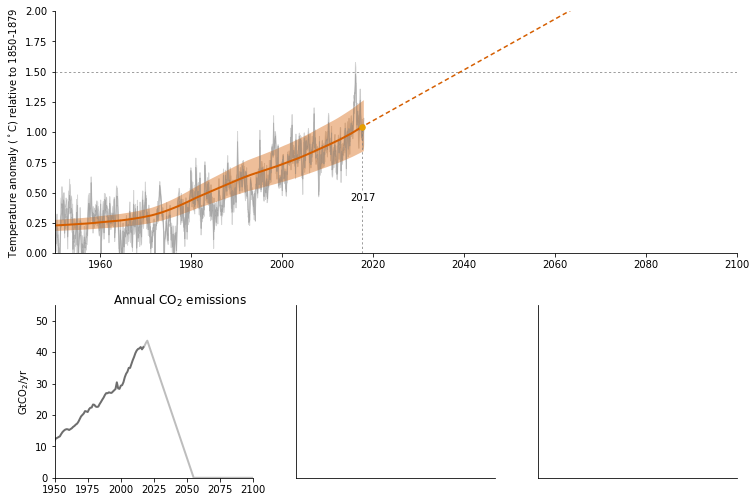

In [11]:
###################################################################
legends = try_or(legends)
lines_left = try_or(lines_left)
lines_middle = try_or(lines_middle)
lines_right = try_or(lines_right)
lines_main = try_or(lines_main)
ax_left.tick_params(colors='black'); left_text.set_color('black') 
ax_middle.tick_params(colors='white'); mid_text.set_color('white')  
ax_right.tick_params(colors='white'); right_text.set_color('white') 
ax_left.set_ylabel('GtCO$_{2}$/yr',fontsize=10)
ax_middle.set_ylabel(''); ax_right.set_ylabel('')
###################################################################



###################################################
### generate annual carbon emissions trajectory ###
###################################################
rf_targs = [0.4]
co2_times_te = np.array([2020,2055,2075])
co2_fracs_te = np.array([1.0,0.0,0.0])

temp_zero_te, llems_zero_te, slcp_zero_te = linear_decline_tozero_test(slcp_mode='parab',rf_targs=rf_targs,
                                                                       co2_times=co2_times_te,
                                                                       co2_fracs=co2_fracs_te, 
                                                                       tcrecs_index=[1])

te = {'years':years,'temp_zero':temp_zero_te,'llems_zero':llems_zero_te,'slcp_zero':slcp_zero_te}
###################################################
###################################################

# import GCP carbon emissions data
gcp_data= np.genfromtxt('./Data/gcp_data_2017_prelim.csv',delimiter=',',
        dtype=np.dtype({'names':['Year','FFI','LUC'],'formats':3*[np.float]}))
gcp_ems = gcp_data['FFI'] + gcp_data['LUC']


line_1, = ax_left.plot(te['years'][te['years'][:]>=2017],44./12*te['llems_zero']['RCP8.5'][0][1][te['years'][:]>=2017],
                       color=stu_cols['line_grey'],linewidth=2, alpha = 0.45)
# line_2 = ax_left.fill_between(te['years'][te['years'][:]>=2017],44./12*te['llems_zero']['RCP8.5'][0][1][te['years'][:]>=2017],
#                               44./12*lb['llems_zero']['RCP8.5'][0][1][lb['years'][:]>=2017],color=stu_cols['line_grey'],linewidth=0,alpha=0.15)
# line_3 = ax_left.fill_between(gcp_data['Year'][gcp_data['Year']>=1850],44./12*gcp_ems[gcp_data['Year']>=1850],
#                               color=stu_cols['line_grey'],alpha=0.15,linewidth=0)
# line_4 = ax_left.fill_between(lb['years'][lb['years'][:]>=2017],44./12*lb['llems_zero']['RCP8.5'][0][1][lb['years'][:]>=2017],
#                               color=stu_cols['line_grey'],alpha=0.15,linewidth=0)
line_5, = ax_left.plot(gcp_data['Year'][gcp_data['Year']>=1850],44./12*gcp_ems[gcp_data['Year']>=1850],
                       color=stu_cols['line_grey'],linewidth=2)
lines_left = [line_1, line_5]#, line_2, line_3, line_4, line_5]

# display figure
display(fig)
fig.savefig('./bookletfigs/plot7.pdf',dpi=300)

<br>
## Plot 8 - Adding cumulative CO2 emissions

Check if lines are already drawn, remove unwanted lines from plot (in hashed region).

Calculate and add the cumulative emissions to middle lower panel.

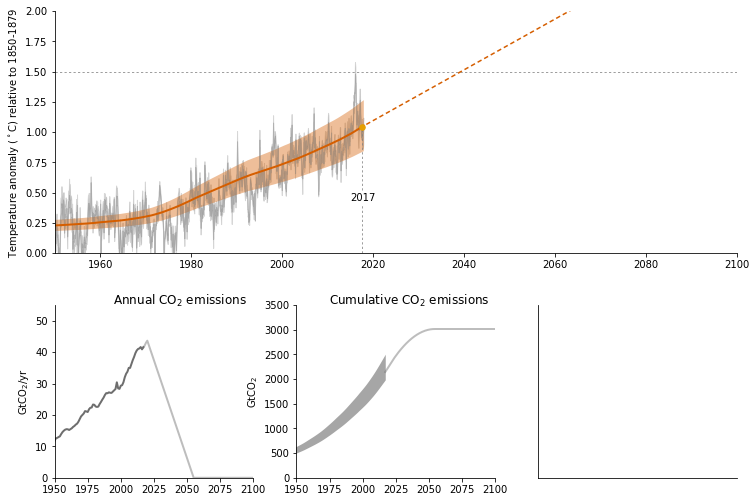

In [12]:
###################################################################
lines_middle = try_or(lines_middle)
lines_right = try_or(lines_right)
lines_main = try_or(lines_main)
ax_middle.tick_params(colors='black'); mid_text.set_color('black')
ax_right.tick_params(colors='white'); right_text.set_color('white')
ax_middle.set_ylabel('GtCO$_{2}$',fontsize=10); ax_right.set_ylabel('')
###################################################################


########################################################
### calculate cumulative carbon emissions trajectory ###
########################################################
cum_high = 44./12*(np.cumsum(te['llems_zero']['RCP8.5'][0][1]))
cum_high = cum_high[te['years'][:]>=2017] - cum_high[te['years'][:]==1870]
# cum_low = 44./12*(np.cumsum(lb['llems_zero']['RCP8.5'][0][1]))
# cum_low = cum_low[lb['years'][:]>=2017] - cum_low[lb['years'][:]==1870]

gcp_ems[0] = 0
cum_gcp = 44./12*np.cumsum(gcp_ems)
cum_gcp = cum_gcp[gcp_data['Year']>=1850] - cum_gcp[gcp_data['Year']==1870]
########################################################
########################################################

# add cumulative emissions to middle panel
line_6, = ax_middle.plot(te['years'][te['years'][:]>=2017],cum_high,color=stu_cols['line_grey'],
                        alpha=0.45,linewidth=2)
#line_7, = ax_middle.plot(gcp_data['Year'][gcp_data['Year']>=1850],cum_gcp,color=stu_cols['line_grey'],
#                         linewidth=2)
error_gcp_data = ax_middle.fill_between(gcp_data['Year'][gcp_data['Year']>=1850],1.11*cum_gcp,0.88*cum_gcp,color='grey',linewidth=0,alpha=0.7)

lines_middle = [line_6, error_gcp_data]

# display figure
display(fig)
fig.savefig('./bookletfigs/plot8.pdf',dpi=300)

<br>

## Plot 9 - Adding non-CO2 radiative forcing contribution

Check if lines are already drawn, remove unwanted lines from plot (in hashed region).

Calculate and add the non-CO2 radiative forcing pathway to right lower panel.

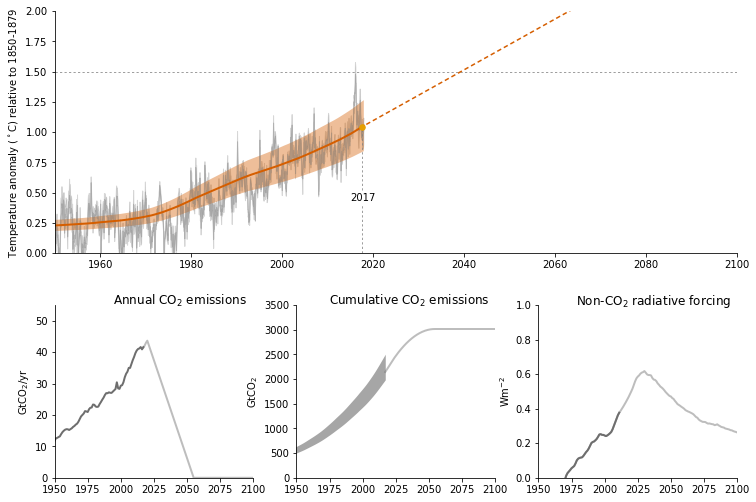

In [13]:
#################################################################
lines_right = try_or(lines_right)
lines_main = try_or(lines_main)
ax_right.tick_params(colors='black'); right_text.set_color('black')
ax_right.set_ylabel('Wm$^{-2}$',fontsize=10)                    
#################################################################



##########################################################
### calculate and add the non-CO2 forcing contribution ###
##########################################################
# ------------
##########################################################
##########################################################

line_8, = ax_right.plot(te['years'],te['slcp_zero']['RCP8.5'][0][1],color=stu_cols['line_grey'],
                        linewidth=2,alpha = 0.45)
line_9, = ax_right.plot(te['years'][te['years'][:]<=2011],
                        te['slcp_zero']['RCP8.5'][0][1][te['years'][:]<=2011],
                        color=stu_cols['line_grey'],linewidth=2)
lines_right = [line_8, line_9]

# #Scale AR5 uncertainty down to likely range 
# mu_nco2 = 0.5*(1.13 + 3.33) - 1.68
# sig_nco2 = (1.13 - 1.68 - mu_nco2)/(erfinv((0.05)*2 - 1)*np.sqrt(2.0))
# nco2_range = sig_nco2 * np.sqrt(2.0) * erfinv(2*(np.array([0.17,0.83])) -1.0) + mu_nco2

# display figure
display(fig)
fig.savefig('./bookletfigs/plot9.pdf',dpi=300)

<br>
## Plot 10 - Adding the most probable warming

Check if lines are already drawn, remove unwanted lines from plot (in hashed region).

Calculate and add the resulting most likely temperature response to main panel.

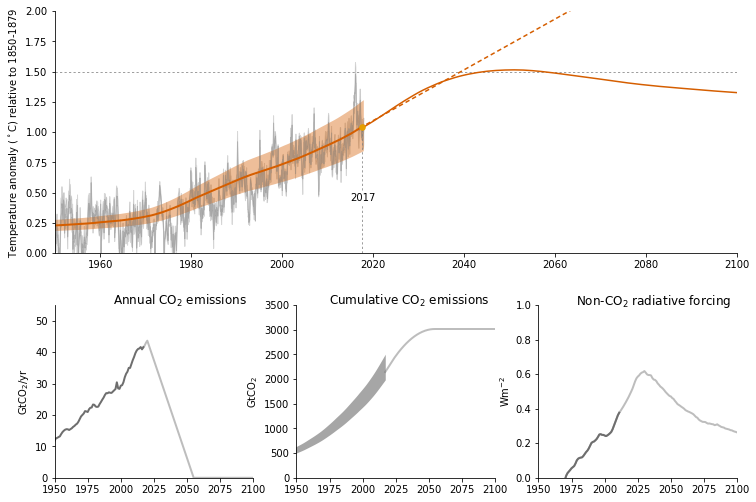

In [14]:
#################################
lines_main = try_or(lines_main) 
#################################

temp_mean, = ax_main_fig.plot(te['years'][te['years'][:]>2017], 
                              te['temp_zero']['RCP8.5'][0][1][te['years'][:]>2017]+0.02, 
                              color=cols['vermillion'])
lines_main = [temp_mean]

# display figure
display(fig)
fig.savefig('./bookletfigs/plot10.pdf', dpi=300)

<br>
## Plot 11 - Adding the upper and lower percentile forcing and temperature response

Check if lines are already drawn, remove unwanted lines from plot (in hashed region).

Calculate and add the resulting temperature lines for central 2/3rds range to main panel.

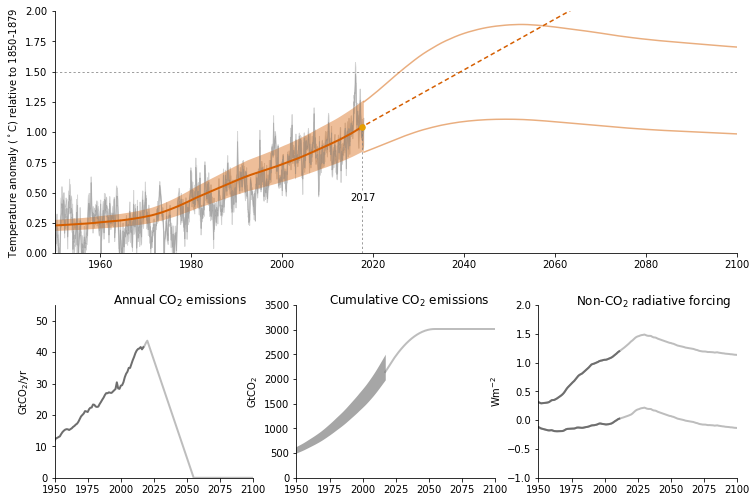

In [15]:
#################################
lines_right = try_or(lines_right)
lines_main = try_or(lines_main)
ax_right.set_ylim(-1,2)
#################################


# calculate the required trajectories for TCR/ECS range in central 2/3rds 
te['temp_zero'], te['llems_zero'], te['slcp_zero'] = linear_decline_tozero_test(slcp_mode='parab',rf_targs=rf_targs,
                                                                                co2_times=np.array([2020,2055,2075]),
                                                                                co2_fracs=np.array([1.0,0.0,0.0]), tcrecs_index=[0,2],
                                                                                temp_zero=te['temp_zero'],llems_zero=te['llems_zero'],
                                                                                slcp_zero=te['slcp_zero'])

# add forcings to the right hand panel
line_8, = ax_right.plot(te['years'],te['slcp_zero']['RCP8.5'][0][0],color=stu_cols['line_grey'],
                        linewidth=2,alpha = 0.45)
line_9, = ax_right.plot(te['years'][te['years'][:]<=2011],
                        te['slcp_zero']['RCP8.5'][0][0][te['years'][:]<=2011],
                        color=stu_cols['line_grey'],linewidth=2)
line_10, = ax_right.plot(te['years'],te['slcp_zero']['RCP8.5'][0][2],color=stu_cols['line_grey'],
                        linewidth=2,alpha = 0.45)
line_11, = ax_right.plot(te['years'][te['years'][:]<=2011],
                        te['slcp_zero']['RCP8.5'][0][2][te['years'][:]<=2011],
                        color=stu_cols['line_grey'],linewidth=2)
lines_right = [line_8, line_9, line_10, line_11]

# add temperature responses to the main panel
temp_upper, = ax_main_fig.plot(te['years'][te['years'][:]>2017], 
                              te['temp_zero']['RCP8.5'][0][2][te['years'][:]>2017]+0.02, 
                              color=cols['vermillion'], alpha=0.5)
temp_lower, = ax_main_fig.plot(te['years'][te['years'][:]>2017], 
                              te['temp_zero']['RCP8.5'][0][0][te['years'][:]>2017]+0.02, 
                              color=cols['vermillion'], alpha=0.5)
lines_main = [temp_upper, temp_lower]

# display figure
display(fig)
fig.savefig('./bookletfigs/plot11.pdf',dpi=300)

<br>
## Plot 12 - Adding resulting warming plumes for scenario

Check if lines are already drawn, remove unwanted lines from plot (in hashed region).

Calculate and add the resulting temperature plumes to main panel.

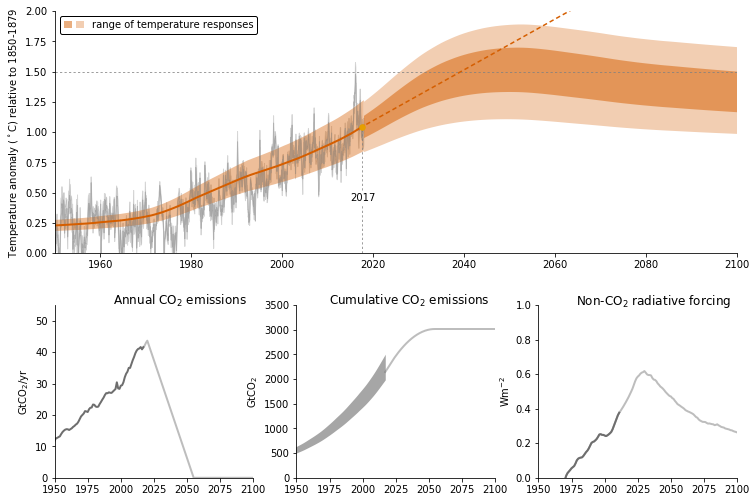

In [16]:
#################################
lines_main = try_or(lines_main) 
lines_right = try_or(lines_right)
ax_right.set_ylim(0,1)
#################################



te['temp_zero'], te['llems_zero'], te['slcp_zero'] = linear_decline_tozero_test(slcp_mode='parab',rf_targs=rf_targs,
                                                                             co2_times=np.array([2020,2055,2075]),
                                                                             co2_fracs=np.array([1.0,0.0,0.0]), tcrecs_index=[3,4],
                                                                             temp_zero=te['temp_zero'],llems_zero=te['llems_zero'],slcp_zero=te['slcp_zero'])

plot_mean = te['temp_zero']['RCP8.5'][0][1] 
# find the relevent ranges for temperaturer plume
plot_uu = te['temp_zero']['RCP8.5'][0][2] 
plot_lu = te['temp_zero']['RCP8.5'][0][3]
plot_ll = te['temp_zero']['RCP8.5'][0][0] 
plot_ul = te['temp_zero']['RCP8.5'][0][4] 


# add most likely forcing to right panel
line_8, = ax_right.plot(te['years'],te['slcp_zero']['RCP8.5'][0][1],color=stu_cols['line_grey'],
                        linewidth=2,alpha = 0.45)
line_9, = ax_right.plot(te['years'][te['years'][:]<=2011],
                        te['slcp_zero']['RCP8.5'][0][1][te['years'][:]<=2011],
                        color=stu_cols['line_grey'],linewidth=2)
lines_right = [line_8, line_9]

# plot to main temperature panel
plume_23rd = ax_main_fig.fill_between(te['years'][te['years'][:]>2017],
                                   plot_ll[te['years'][:]>2017]+0.02,plot_uu[te['years'][:]>2017]+0.02,
                                   color=cols['vermillion'],alpha=0.3,linewidth=0)
plume_13rd = ax_main_fig.fill_between(te['years'][te['years'][:]>2017],
                                   plot_lu[te['years'][:]>2017]+0.02,plot_ul[te['years'][:]>2017]+0.02,
                                   color=cols['vermillion'],alpha=0.5,linewidth=0)
lines_main = [plume_23rd,plume_13rd]

#Create custom artists
rect1 = patches.Rectangle((50,100),40,30,linewidth=1,edgecolor='none',facecolor=cols['vermillion'],alpha=0.5)
rect2 = patches.Rectangle((50,100),40,30,linewidth=1,edgecolor='none',facecolor=cols['vermillion'],alpha=0.3)

#Create legend from custom artist/label lists
legends = try_or(legends)
legend12 = ax_main_fig.legend([(rect1, rect2)], ['range of temperature responses'], numpoints=1,
               handler_map={tuple: HandlerTuple(ndivide=None)}, loc='upper left', framealpha=1, edgecolor='black')
legends = [legend12]

# display figure
display(fig)
fig.savefig('./bookletfigs/plot12.pdf',dpi=300)

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

<br>

In [17]:
co2_times_lb = np.array([2020,2040,2060,2075])
co2_fracs_lb = np.array([1.0,0.0,0.0,0.0])

temp_zero_lb, llems_zero_lb, slcp_zero_lb = linear_decline_tozero_test(slcp_mode='parab',rf_targs=[0.4],
                                                                       co2_times=co2_times_lb,
                                                                       co2_fracs=co2_fracs_lb, 
                                                                       tcrecs_index=[0,1,2,3,4])

lb = {'years':years,'temp_zero':temp_zero_lb,'llems_zero':llems_zero_lb,'slcp_zero':slcp_zero_lb}



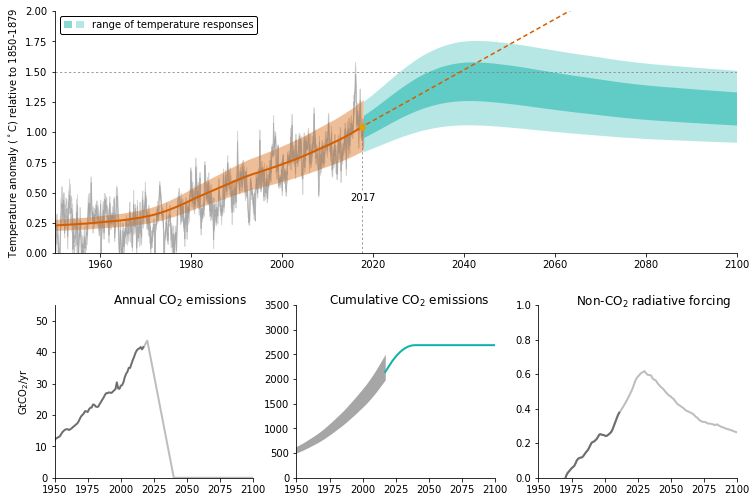

In [18]:
###############################################################################
###############################################################################
# DEFINE THE SPM FIGURE 1 SHAPE
###############################################################################
###############################################################################
                                                                                                    
# define a figure shape - locations and sizes of axes
main_xstart = 0.13; main_xwidth = 0.79; main_ystart = 0.50; main_ywidth = 0.42
left_xstart = 0.13; left_xwidth = 0.23; left_ystart = 0.11; left_ywidth = 0.30
mid_xstart = 0.41; mid_xwidth = 0.23; mid_ystart = 0.11; mid_ywidth = 0.30
right_xstart = 0.69; right_xwidth = 0.23; right_ystart = 0.11; right_ywidth = 0.30

# define the figure
fig = plt.figure(figsize=(12,8))
# define the left subplot
ax_left = fig.add_axes([left_xstart,left_ystart,left_xwidth,left_ywidth])
ax_left.spines['right'].set_visible(False)
ax_left.spines['top'].set_visible(False)
#ax_left.tick_params(colors='white')
ax_left.set_xlim(1950,2100)
ax_left.set_ylim(0,55)
left_text = ax_left.text(0.97,1.0,'Annual CO$_{2}$ emissions',fontsize=12,
                         transform=ax_left.transAxes,ha='right',color='black')
# define the middle subplot
ax_middle = fig.add_axes([mid_xstart,mid_ystart,mid_xwidth,mid_ywidth])
ax_middle.spines['right'].set_visible(False)
ax_middle.spines['top'].set_visible(False)
#ax_middle.tick_params(colors='white')
ax_middle.set_xlim(1950,2100)
ax_middle.set_ylim(0,3500)
mid_text = ax_middle.text(0.97,1.0,'Cumulative CO$_{2}$ emissions', 
               fontsize=12,transform=ax_middle.transAxes, 
               ha='right', color='black')
# define the right subplot
ax_right = fig.add_axes([right_xstart,right_ystart,right_xwidth,right_ywidth])
ax_right.spines['right'].set_visible(False)
ax_right.spines['top'].set_visible(False)
#ax_right.tick_params(colors='white')
ax_right.set_xlim(1950,2100)
ax_right.set_ylim(0,1)
right_text = ax_right.text(0.97,1.0,'Non-CO$_{2}$ radiative forcing', 
               fontsize=12,transform=ax_right.transAxes, 
               ha='right', color='black')
# define the main subplot
ax_main_fig = fig.add_axes([main_xstart,main_ystart,main_xwidth,main_ywidth])
ax_main_fig.spines['right'].set_visible(False)
ax_main_fig.spines['top'].set_visible(False)
ax_main_fig.set_xlim(1950,2100)
ax_main_fig.set_ylim(0,2)
ax_main_fig.set_ylabel(r'Temperature anomaly ($^\circ$C) relative to 1850-1879')

# add the lines which were on the last plot to this one
ax_main_fig.fill_between(gmst['HadCRUT4']['Years'],gmst['Temp-max'],gmst['Temp-min'],
                     color='grey',alpha=0.3)
ax_main_fig.plot(gmst['HadCRUT4']['Years'],np.array(gmst['Temp-mean']),color='grey',
             linestyle='-',linewidth=1, alpha = 0.4)
ax_main_fig.plot(gmst['HadCRUT4']['Years'], gmst['Temp-mean-AWI'], color=cols['vermillion'],
             linestyle='-', linewidth=2)
ax_main_fig.fill_between(gmst['HadCRUT4']['Years'],gmst['Temp-mean-AWI']*(1.2),
                 gmst['Temp-mean-AWI']*(0.8),color=cols['vermillion'],
                 alpha=0.4,linewidth=0)

# prepare arrays to contain the lines in each of the created subplots
lines_main = None
lines_right = None
lines_middle = None
lines_left = None
###############################################################################
###############################################################################
# END OF MAIN FIGURE CREATION
###############################################################################
ax_left.tick_params(colors='black'); left_text.set_color('black') 
ax_left.set_ylabel('GtCO$_{2}$/yr',fontsize=10)

###############################################################################



# Add a line showing the position of 2017 and current temperature gradient
#  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  
warm_end = np.mean(gmst['Temp-mean-AWI'][np.logical_and(np.array(gmst['HadCRUT4']['Years'])>=2017,
                   np.array(gmst['HadCRUT4']['Years'])<2018)])
    
#ax_main.plot([1950.,2017.5],[warm_end,warm_end],linestyle='--',linewidth=1.5,color=awi_col)
ax_main_fig.scatter(2017.5,warm_end,s=30,color=cols['orange'],zorder=20)

#Add projection for current warming rate 
proj_years = np.arange(2018,2100)
warm_rate = 0.021
ax_main_fig.plot(proj_years+0.5,warm_end+warm_rate*(proj_years+0.5-2017.5),linestyle='--',
                 dashes=(3, 2),color=cols['vermillion'],linewidth=1.5,zorder=10, label='if current warming rate continues')

ax_main_fig.axhline(y=1.5,linewidth=0.75,linestyle='--',dashes=(3,3),color='grey')
ax_main_fig.text(2015,0.43,'2017',fontsize=10,color='black')
ax_main_fig.plot([2017.5,2017.5],[0,0.40],linestyle='--',dashes=(3,3),linewidth=0.75,color='grey')
ax_main_fig.plot([2017.5,2017.5],[0.52,warm_end],linestyle='--',dashes=(3,3),linewidth=0.75,color='grey')

#  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  


line_1, = ax_left.plot(te['years'][lb['years'][:]>=2017],44./12*lb['llems_zero']['RCP8.5'][0][1][lb['years'][:]>=2017],
                       color=stu_cols['line_grey'],linewidth=2, alpha = 0.45)
# line_2 = ax_left.fill_between(te['years'][te['years'][:]>=2017],44./12*te['llems_zero']['RCP8.5'][0][1][te['years'][:]>=2017],
#                               44./12*lb['llems_zero']['RCP8.5'][0][1][lb['years'][:]>=2017],color=stu_cols['line_grey'],linewidth=0,alpha=0.15)
# line_3 = ax_left.fill_between(gcp_data['Year'][gcp_data['Year']>=1850],44./12*gcp_ems[gcp_data['Year']>=1850],
#                               color=stu_cols['line_grey'],alpha=0.15,linewidth=0)
# line_4 = ax_left.fill_between(lb['years'][lb['years'][:]>=2017],44./12*lb['llems_zero']['RCP8.5'][0][1][lb['years'][:]>=2017],
#                               color=stu_cols['line_grey'],alpha=0.15,linewidth=0)
line_5, = ax_left.plot(gcp_data['Year'][gcp_data['Year']>=1850],44./12*gcp_ems[gcp_data['Year']>=1850],
                       color=stu_cols['line_grey'],linewidth=2)
lines_left = [line_1, line_5]

#  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  

cum_high = 44./12*(np.cumsum(lb['llems_zero']['RCP8.5'][0][1]))
cum_high = cum_high[lb['years'][:]>=2017] - cum_high[lb['years'][:]==1870]
# cum_low = 44./12*(np.cumsum(lb['llems_zero']['RCP8.5'][0][1]))
# cum_low = cum_low[lb['years'][:]>=2017] - cum_low[lb['years'][:]==1870]

gcp_ems[0] = 0
cum_gcp = 44./12*np.cumsum(gcp_ems)
cum_gcp = cum_gcp[gcp_data['Year']>=1850] - cum_gcp[gcp_data['Year']==1870]

# add cumulative emissions to middle panel
line_6, = ax_middle.plot(lb['years'][lb['years'][:]>=2017],cum_high,color=stu_cols['line_blue'],
                        alpha=1,linewidth=2)
error_gcp_data = ax_middle.fill_between(gcp_data['Year'][gcp_data['Year']>=1850],1.11*cum_gcp,0.88*cum_gcp,color='grey',linewidth=0,alpha=0.7)

lines_middle = [line_6, error_gcp_data]

#  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  

line_8, = ax_right.plot(lb['years'],lb['slcp_zero']['RCP8.5'][0][1],color=stu_cols['line_grey'],
                        linewidth=2,alpha = 0.45)
line_9, = ax_right.plot(lb['years'][lb['years'][:]<=2011],
                        lb['slcp_zero']['RCP8.5'][0][1][lb['years'][:]<=2011],
                        color=stu_cols['line_grey'],linewidth=2)
lines_right = [line_8, line_9]

#  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  

# find the relevent ranges for temperaturer plume
plot_uu = lb['temp_zero']['RCP8.5'][0][2] 
plot_lu = lb['temp_zero']['RCP8.5'][0][3]
plot_ll = lb['temp_zero']['RCP8.5'][0][0] 
plot_ul = lb['temp_zero']['RCP8.5'][0][4] 

# plot to main temperature panel
plume_23rd = ax_main_fig.fill_between(lb['years'][lb['years'][:]>2017],
                                   plot_ll[lb['years'][:]>2017]+0.02,plot_uu[lb['years'][:]>2017]+0.02,
                                   color=stu_cols['line_blue'],alpha=0.3,linewidth=0)
plume_13rd = ax_main_fig.fill_between(lb['years'][lb['years'][:]>2017],
                                   plot_lu[lb['years'][:]>2017]+0.02,plot_ul[lb['years'][:]>2017]+0.02,
                                   color=stu_cols['line_blue'],alpha=0.5,linewidth=0)
lines_main = [plume_23rd,plume_13rd]

#Create custom artists
rect1 = patches.Rectangle((50,100),40,30,linewidth=1,edgecolor='none',facecolor=stu_cols['line_blue'],alpha=0.5)
rect2 = patches.Rectangle((50,100),40,30,linewidth=1,edgecolor='none',facecolor=stu_cols['line_blue'],alpha=0.3)

#Create legend from custom artist/label lists
legends = try_or(legends)
legend12 = ax_main_fig.legend([(rect1, rect2)], ['range of temperature responses'], numpoints=1,
               handler_map={tuple: HandlerTuple(ndivide=None)}, loc='upper left', framealpha=1, edgecolor='black')
legends = [legend12]

plt.show()
fig.savefig('./bookletfigs/plot13.pdf',dpi=300)

In [19]:
temp_zero_te2, llems_zero_te2, slcp_zero_te2 = linear_decline_tozero_test(slcp_mode='parab',rf_targs=[0.8],
                                                                       co2_times=co2_times_te,
                                                                       co2_fracs=co2_fracs_te, 
                                                                       tcrecs_index=[0,1,2,3,4])

te2 = {'years':years,'temp_zero':temp_zero_te2,'llems_zero':llems_zero_te2,'slcp_zero':slcp_zero_te2}

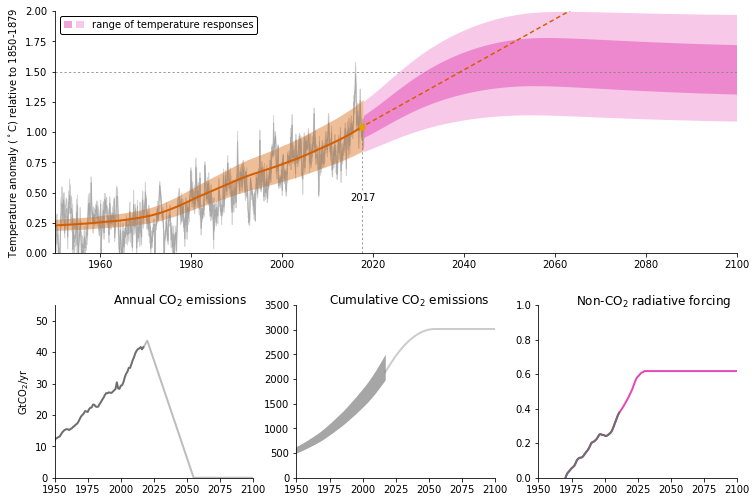

In [20]:
###############################################################################
###############################################################################
# DEFINE THE SPM FIGURE 1 SHAPE
###############################################################################
###############################################################################
                                                                                                    
# define a figure shape - locations and sizes of axes
main_xstart = 0.13; main_xwidth = 0.79; main_ystart = 0.50; main_ywidth = 0.42
left_xstart = 0.13; left_xwidth = 0.23; left_ystart = 0.11; left_ywidth = 0.30
mid_xstart = 0.41; mid_xwidth = 0.23; mid_ystart = 0.11; mid_ywidth = 0.30
right_xstart = 0.69; right_xwidth = 0.23; right_ystart = 0.11; right_ywidth = 0.30

# define the figure
fig = plt.figure(figsize=(12,8))
# define the left subplot
ax_left = fig.add_axes([left_xstart,left_ystart,left_xwidth,left_ywidth])
ax_left.spines['right'].set_visible(False)
ax_left.spines['top'].set_visible(False)
#ax_left.tick_params(colors='white')
ax_left.set_xlim(1950,2100)
ax_left.set_ylim(0,55)
left_text = ax_left.text(0.97,1.0,'Annual CO$_{2}$ emissions',fontsize=12,
                         transform=ax_left.transAxes,ha='right',color='black')
# define the middle subplot
ax_middle = fig.add_axes([mid_xstart,mid_ystart,mid_xwidth,mid_ywidth])
ax_middle.spines['right'].set_visible(False)
ax_middle.spines['top'].set_visible(False)
#ax_middle.tick_params(colors='white')
ax_middle.set_xlim(1950,2100)
ax_middle.set_ylim(0,3500)
mid_text = ax_middle.text(0.97,1.0,'Cumulative CO$_{2}$ emissions', 
               fontsize=12,transform=ax_middle.transAxes, 
               ha='right', color='black')
# define the right subplot
ax_right = fig.add_axes([right_xstart,right_ystart,right_xwidth,right_ywidth])
ax_right.spines['right'].set_visible(False)
ax_right.spines['top'].set_visible(False)
#ax_right.tick_params(colors='white')
ax_right.set_xlim(1950,2100)
ax_right.set_ylim(0,1)
right_text = ax_right.text(0.97,1.0,'Non-CO$_{2}$ radiative forcing', 
               fontsize=12,transform=ax_right.transAxes, 
               ha='right', color='black')
# define the main subplot
ax_main_fig = fig.add_axes([main_xstart,main_ystart,main_xwidth,main_ywidth])
ax_main_fig.spines['right'].set_visible(False)
ax_main_fig.spines['top'].set_visible(False)
ax_main_fig.set_xlim(1950,2100)
ax_main_fig.set_ylim(0,2)
ax_main_fig.set_ylabel(r'Temperature anomaly ($^\circ$C) relative to 1850-1879')

# add the lines which were on the last plot to this one
ax_main_fig.fill_between(gmst['HadCRUT4']['Years'],gmst['Temp-max'],gmst['Temp-min'],
                     color='grey',alpha=0.3)
ax_main_fig.plot(gmst['HadCRUT4']['Years'],np.array(gmst['Temp-mean']),color='grey',
             linestyle='-',linewidth=1, alpha = 0.4)
ax_main_fig.plot(gmst['HadCRUT4']['Years'], gmst['Temp-mean-AWI'], color=cols['vermillion'],
             linestyle='-', linewidth=2)
ax_main_fig.fill_between(gmst['HadCRUT4']['Years'],gmst['Temp-mean-AWI']*(1.2),
                 gmst['Temp-mean-AWI']*(0.8),color=cols['vermillion'],
                 alpha=0.4,linewidth=0)

# prepare arrays to contain the lines in each of the created subplots
lines_main = None
lines_right = None
lines_middle = None
lines_left = None
###############################################################################
###############################################################################
# END OF MAIN FIGURE CREATION
###############################################################################
ax_left.tick_params(colors='black'); left_text.set_color('black') 
ax_left.set_ylabel('GtCO$_{2}$/yr',fontsize=10)

###############################################################################



# Add a line showing the position of 2017 and current temperature gradient
#  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  
warm_end = np.mean(gmst['Temp-mean-AWI'][np.logical_and(np.array(gmst['HadCRUT4']['Years'])>=2017,
                   np.array(gmst['HadCRUT4']['Years'])<2018)])
    
#ax_main.plot([1950.,2017.5],[warm_end,warm_end],linestyle='--',linewidth=1.5,color=awi_col)
ax_main_fig.scatter(2017.5,warm_end,s=30,color=cols['orange'],zorder=20)

#Add projection for current warming rate 
proj_years = np.arange(2018,2100)
warm_rate = 0.021
ax_main_fig.plot(proj_years+0.5,warm_end+warm_rate*(proj_years+0.5-2017.5),linestyle='--',
                 dashes=(3, 2),color=cols['vermillion'],linewidth=1.5,zorder=10, label='if current warming rate continues')

ax_main_fig.axhline(y=1.5,linewidth=0.75,linestyle='--',dashes=(3,3),color='grey')
ax_main_fig.text(2015,0.43,'2017',fontsize=10,color='black')
ax_main_fig.plot([2017.5,2017.5],[0,0.40],linestyle='--',dashes=(3,3),linewidth=0.75,color='grey')
ax_main_fig.plot([2017.5,2017.5],[0.52,warm_end],linestyle='--',dashes=(3,3),linewidth=0.75,color='grey')

#  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  


line_1, = ax_left.plot(te2['years'][te2['years'][:]>=2017],44./12*te2['llems_zero']['RCP8.5'][0][1][te2['years'][:]>=2017],
                       color=stu_cols['line_grey'],linewidth=2, alpha = 0.45)
# line_2 = ax_left.fill_between(te['years'][te['years'][:]>=2017],44./12*te['llems_zero']['RCP8.5'][0][1][te['years'][:]>=2017],
#                               44./12*lb['llems_zero']['RCP8.5'][0][1][lb['years'][:]>=2017],color=stu_cols['line_grey'],linewidth=0,alpha=0.15)
# line_3 = ax_left.fill_between(gcp_data['Year'][gcp_data['Year']>=1850],44./12*gcp_ems[gcp_data['Year']>=1850],
#                               color=stu_cols['line_grey'],alpha=0.15,linewidth=0)
# line_4 = ax_left.fill_between(lb['years'][lb['years'][:]>=2017],44./12*lb['llems_zero']['RCP8.5'][0][1][lb['years'][:]>=2017],
#                               color=stu_cols['line_grey'],alpha=0.15,linewidth=0)
line_5, = ax_left.plot(gcp_data['Year'][gcp_data['Year']>=1850],44./12*gcp_ems[gcp_data['Year']>=1850],
                       color=stu_cols['line_grey'],linewidth=2)
lines_left = [line_1, line_5]

#  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  

cum_high = 44./12*(np.cumsum(te2['llems_zero']['RCP8.5'][0][1]))
cum_high = cum_high[te2['years'][:]>=2017] - cum_high[te2['years'][:]==1870]
# cum_low = 44./12*(np.cumsum(lb['llems_zero']['RCP8.5'][0][1]))
# cum_low = cum_low[lb['years'][:]>=2017] - cum_low[lb['years'][:]==1870]

gcp_ems[0] = 0
cum_gcp = 44./12*np.cumsum(gcp_ems)
cum_gcp = cum_gcp[gcp_data['Year']>=1850] - cum_gcp[gcp_data['Year']==1870]

# add cumulative emissions to middle panel
line_6, = ax_middle.plot(te2['years'][te2['years'][:]>=2017],cum_high,color=stu_cols['line_grey'],
                        alpha=0.35,linewidth=2)
error_gcp_data = ax_middle.fill_between(gcp_data['Year'][gcp_data['Year']>=1850],1.11*cum_gcp,0.88*cum_gcp,color='grey',linewidth=0,alpha=0.7)

lines_middle = [line_6, error_gcp_data]

#  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  

line_8, = ax_right.plot(te2['years'],te2['slcp_zero']['RCP8.5'][0][1],color=stu_cols['line_purple'],
                        linewidth=2,alpha = 1)
line_9, = ax_right.plot(te2['years'][te2['years'][:]<=2011],
                        te2['slcp_zero']['RCP8.5'][0][1][te2['years'][:]<=2011],
                        color=stu_cols['line_grey'],linewidth=2)
lines_right = [line_8, line_9]

#  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  --  

# find the relevent ranges for temperaturer plume
plot_uu = te2['temp_zero']['RCP8.5'][0][2] 
plot_lu = te2['temp_zero']['RCP8.5'][0][3]
plot_ll = te2['temp_zero']['RCP8.5'][0][0] 
plot_ul = te2['temp_zero']['RCP8.5'][0][4] 

# plot to main temperature panel
plume_23rd_te2 = ax_main_fig.fill_between(te2['years'][te2['years'][:]>2017],
                                   plot_ll[te2['years'][:]>2017]+0.02,plot_uu[te2['years'][:]>2017]+0.02,
                                   color=stu_cols['line_purple'],alpha=0.3,linewidth=0)
plume_13rd_te2 = ax_main_fig.fill_between(te2['years'][te2['years'][:]>2017],
                                   plot_lu[te2['years'][:]>2017]+0.02,plot_ul[te2['years'][:]>2017]+0.02,
                                   color=stu_cols['line_purple'],alpha=0.5,linewidth=0)
lines_main = [plume_23rd_te2,plume_13rd_te2]

#Create custom artists
rect1 = patches.Rectangle((50,100),40,30,linewidth=1,edgecolor='none',facecolor=stu_cols['line_purple'],alpha=0.5)
rect2 = patches.Rectangle((50,100),40,30,linewidth=1,edgecolor='none',facecolor=stu_cols['line_purple'],alpha=0.3)

#Create legend from custom artist/label lists
legends = try_or(legends)
legend12 = ax_main_fig.legend([(rect1, rect2)], ['range of temperature responses'], numpoints=1,
               handler_map={tuple: HandlerTuple(ndivide=None)}, loc='upper left', framealpha=1, edgecolor='black')
legends = [legend12]

plt.show()
fig.savefig('./bookletfigs/plot14.pdf',dpi=300)